In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import community
from scipy.sparse import csr_matrix, diags
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from sklearn.preprocessing import normalize
from tqdm import tqdm
import pandas as pd
import time
import community as community_louvain
import os
import random



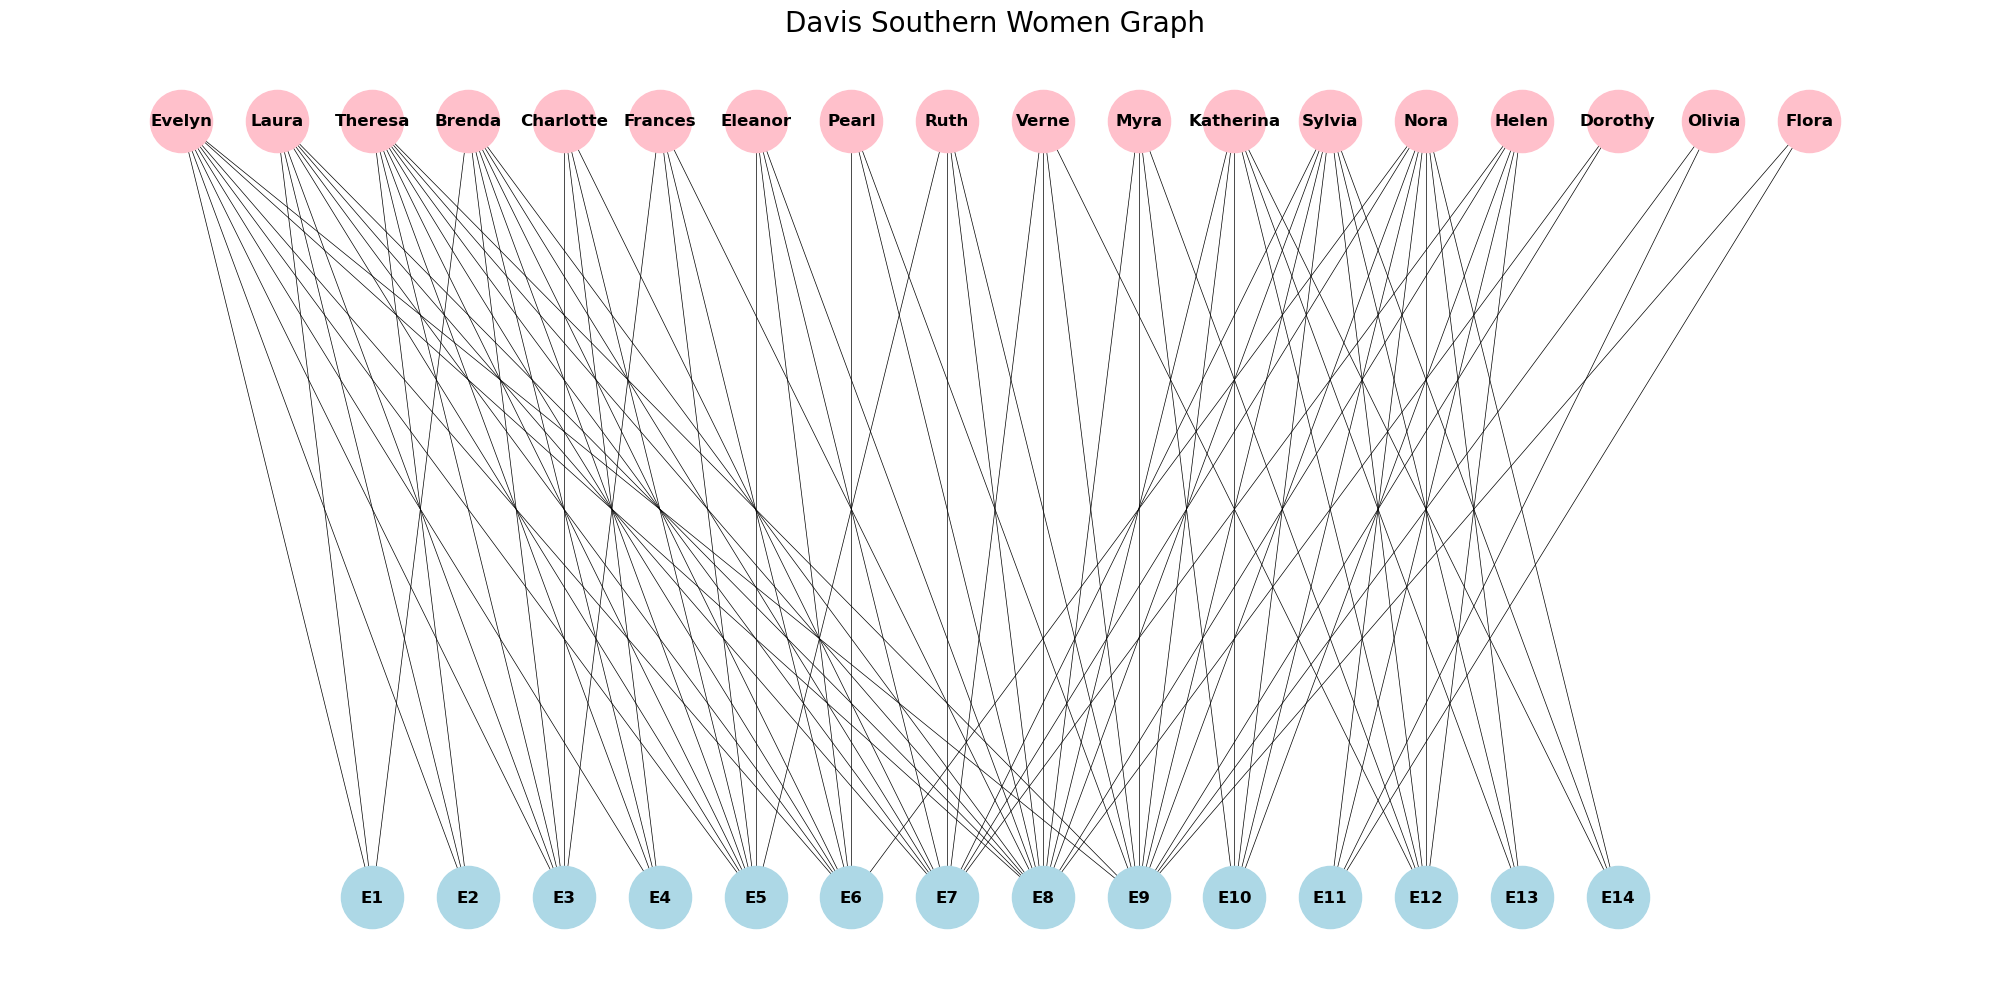

In [2]:
G = nx.davis_southern_women_graph()
# Separate the nodes into the two partitions
women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
events = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

# Create the position dictionary with more spacing
pos = {}
pos.update((node, (i*1.5 - len(women)*0.75, 1)) for i, node in enumerate(women))
pos.update((node, (i*1.5 - len(events)*0.75, 0)) for i, node in enumerate(events))

# Create the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Draw the graph with different colors for women and events
nx.draw_networkx_nodes(G, pos, nodelist=women, node_color='pink', node_size=2000, ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=events, node_color='lightblue', node_size=2000, ax=ax)
nx.draw_networkx_edges(G, pos, width=0.5, ax=ax)

# Add labels to nodes with offset
label_pos = {k: (v[0], v[1]) for k, v in pos.items()}

# Create label dictionaries
women_labels = {node: node.split()[0] for node in women}  # First names only for women
event_labels = {node: node for node in events}

# Draw women labels with rotation
nx.draw_networkx_labels(G, label_pos, women_labels, font_size=12, font_weight='bold', 
                        ax=ax, horizontalalignment='center')

# Draw event labels
nx.draw_networkx_labels(G, label_pos, event_labels, font_size=12, font_weight='bold', ax=ax)

plt.title("Davis Southern Women Graph", fontsize=20)
plt.axis('off')
plt.tight_layout()
# Save the figure
plt.savefig('figures/bipartite_graph_plot.png', dpi=300, bbox_inches='tight')

plt.show()



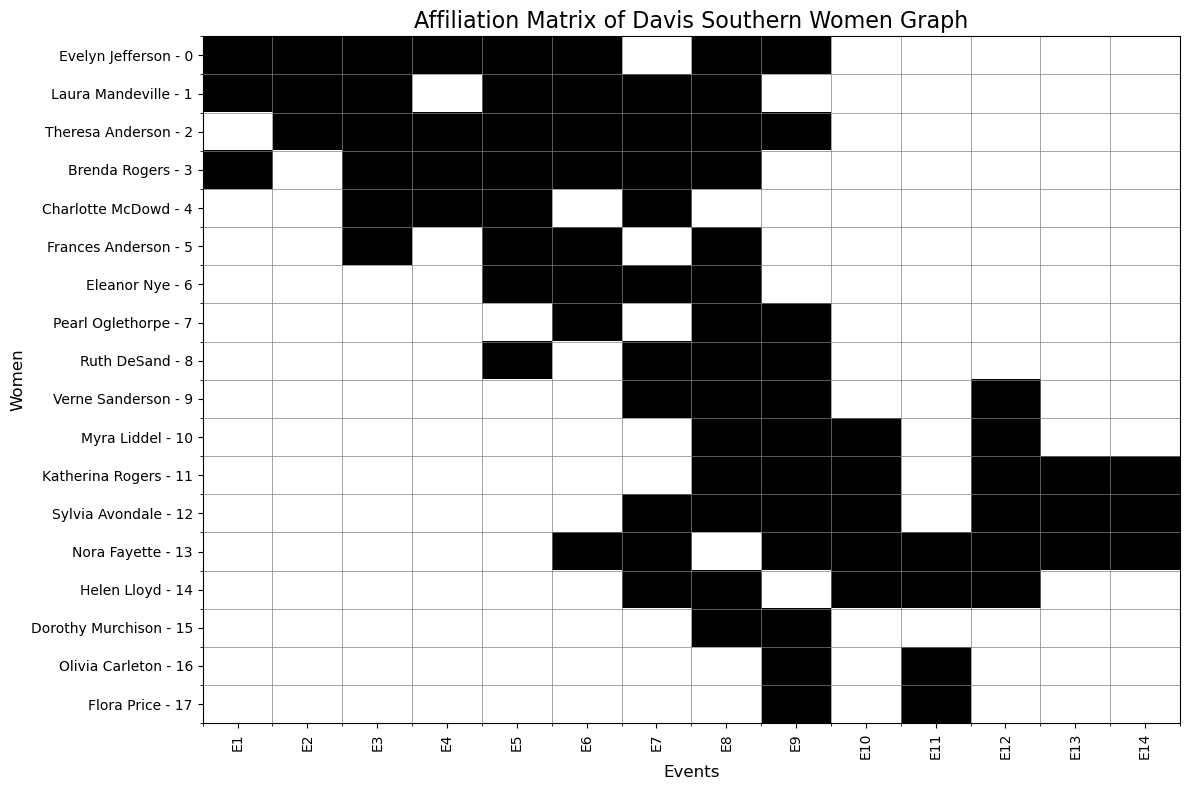

In [3]:
# Separate the nodes into the two partitions
women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
events = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

# Create the affiliation matrix
affiliation_matrix = nx.bipartite.biadjacency_matrix(G, row_order=women, column_order=events).todense()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Display the affiliation matrix as an image
im = ax.imshow(affiliation_matrix, cmap='gray_r', interpolation='nearest', aspect='auto')

# Set the ticks
ax.set_xticks(np.arange(len(events)))
ax.set_yticks(np.arange(len(women)))

# Label the ticks
ax.set_xticklabels(events, rotation=90)
ax.set_yticklabels([woman+str(f' - {i}') for i, woman in enumerate(women)])  # Using first names for women

# Add labels to the axes
ax.set_xlabel('Events', fontsize=12)
ax.set_ylabel('Women', fontsize=12)

# Add a title
plt.title("Affiliation Matrix of Davis Southern Women Graph", fontsize=16)

# Offset the grid
ax.set_xticks(np.arange(affiliation_matrix.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(affiliation_matrix.shape[0]+1)-.5, minor=True)

# Add grey lines separating columns and rows
ax.grid(which="minor", color="grey", linestyle='-', linewidth=0.5)

# Turn off the major grid
ax.grid(which="major", visible=False)

# Adjust the layout and display
plt.tight_layout()
plt.savefig('figures/incidence_matrix_plot.png', dpi=300, bbox_inches='tight')

plt.show()



In [5]:
from networkx.algorithms import bipartite

# Create the graph
G = nx.davis_southern_women_graph()

# Get the two sets of nodes
women = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
events = set(G) - women

# Create the projections with weights
women_graph = nx.bipartite.weighted_projected_graph(G, women)
events_graph = nx.bipartite.weighted_projected_graph(G, events)

# Calculate densities
density_G = bipartite.density(G, women)  # or events, either will work
density_women = nx.density(women_graph)
density_events = nx.density(events_graph)

print(f"Density of bipartite graph G: {density_G:.4f}")
print(f"Density of women projection graph: {density_women:.4f}")
print(f"Density of events projection graph: {density_events:.4f}")

Density of bipartite graph G: 0.3532
Density of women projection graph: 0.9085
Density of events projection graph: 0.7253


In [4]:
def bipartite_density(G):
    top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
    bottom_nodes = set(G) - top_nodes
    edges = G.number_of_edges()
    max_edges = len(top_nodes) * len(bottom_nodes)
    return edges / max_edges

def undirected_density(G):
    n = G.number_of_nodes()
    e = G.number_of_edges()
    return (2 * e) / (n * (n - 1))


# Create the projections with weights
women_graph = nx.bipartite.weighted_projected_graph(G, women)
events_graph = nx.bipartite.weighted_projected_graph(G, events)
# Calculate densities
density_G = bipartite_density(G)
density_women = undirected_density(women_graph)
density_events = undirected_density(events_graph)

print(f"Density of bipartite graph G: {density_G:.4f}")
print(f"Density of women projection graph: {density_women:.4f}")
print(f"Density of events projection graph: {density_events:.4f}")

Density of bipartite graph G: 0.3532
Density of women projection graph: 0.9085
Density of events projection graph: 0.7253


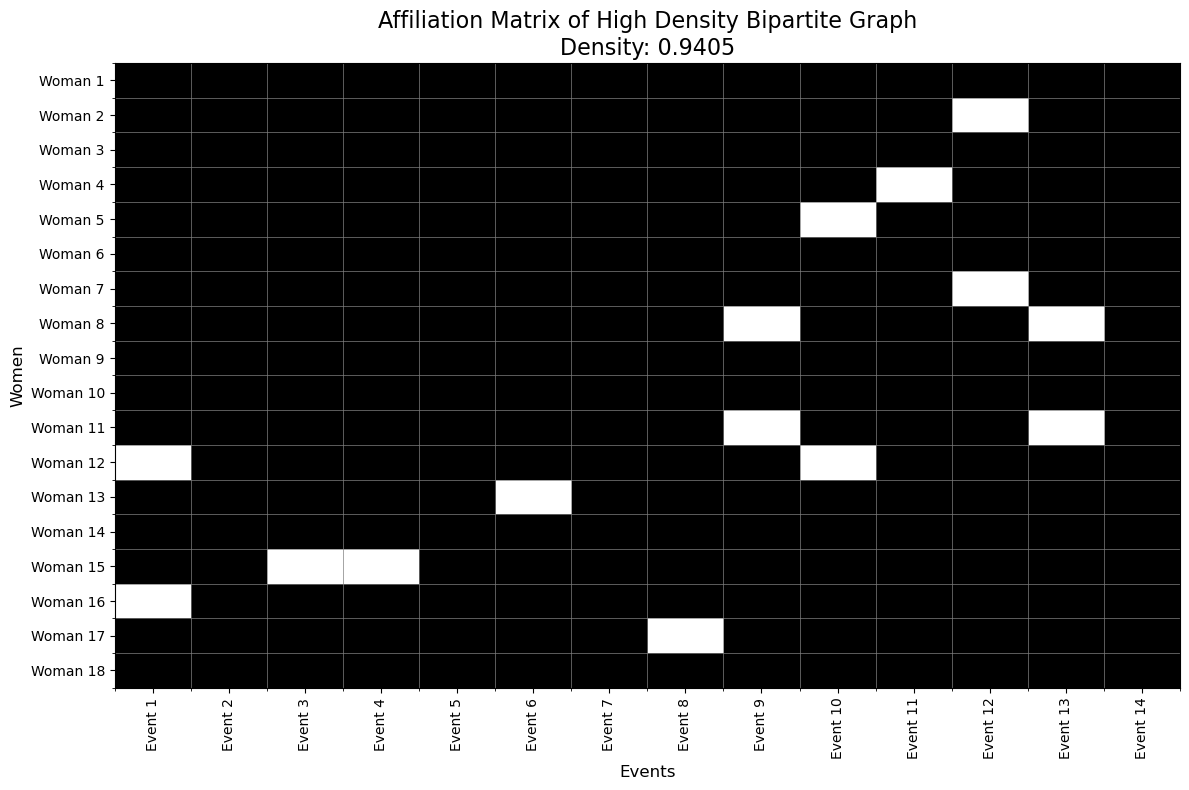

Actual density: 0.9405


In [8]:

def generate_high_density_bipartite(n_top, n_bottom, density=0.95):
    G = nx.Graph()
    G.add_nodes_from(range(n_top), bipartite=0)
    G.add_nodes_from(range(n_top, n_top + n_bottom), bipartite=1)
    
    for i in range(n_top):
        for j in range(n_top, n_top + n_bottom):
            if random.random() < density:
                G.add_edge(i, j)
    
    return G

def plot_bipartite_matrix(G, filename):
    top_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
    bottom_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]
    
    affiliation_matrix = nx.bipartite.biadjacency_matrix(G, row_order=top_nodes, column_order=bottom_nodes).todense()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(affiliation_matrix, cmap='gray_r', interpolation='nearest', aspect='auto')
    
    ax.set_xticks(np.arange(len(bottom_nodes)))
    ax.set_yticks(np.arange(len(top_nodes)))
    
    ax.set_xticklabels([f'Event {i+1}' for i in range(len(bottom_nodes))], rotation=90)
    ax.set_yticklabels([f'Woman {i+1}' for i in range(len(top_nodes))])
    
    ax.set_xlabel('Events', fontsize=12)
    ax.set_ylabel('Women', fontsize=12)
    
    plt.title(f"Affiliation Matrix of High Density Bipartite Graph\nDensity: {nx.bipartite.density(G, top_nodes):.4f}", fontsize=16)
    
    ax.set_xticks(np.arange(affiliation_matrix.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(affiliation_matrix.shape[0]+1)-.5, minor=True)
    
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=0.5)
    ax.grid(which="major", visible=False)
    
    plt.tight_layout()
    # plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Generate and plot a high density bipartite graph
n_women = 18  # Same as in Davis Southern Women graph
n_events = 14  # Same as in Davis Southern Women graph
high_density_graph = generate_high_density_bipartite(n_women, n_events, density=0.95)

plot_bipartite_matrix(high_density_graph, 'figures/high_density_bipartite_matrix.png')

# Print the actual density
top_nodes = [n for n, d in high_density_graph.nodes(data=True) if d['bipartite'] == 0]
print(f"Actual density: {nx.bipartite.density(high_density_graph, top_nodes):.4f}")

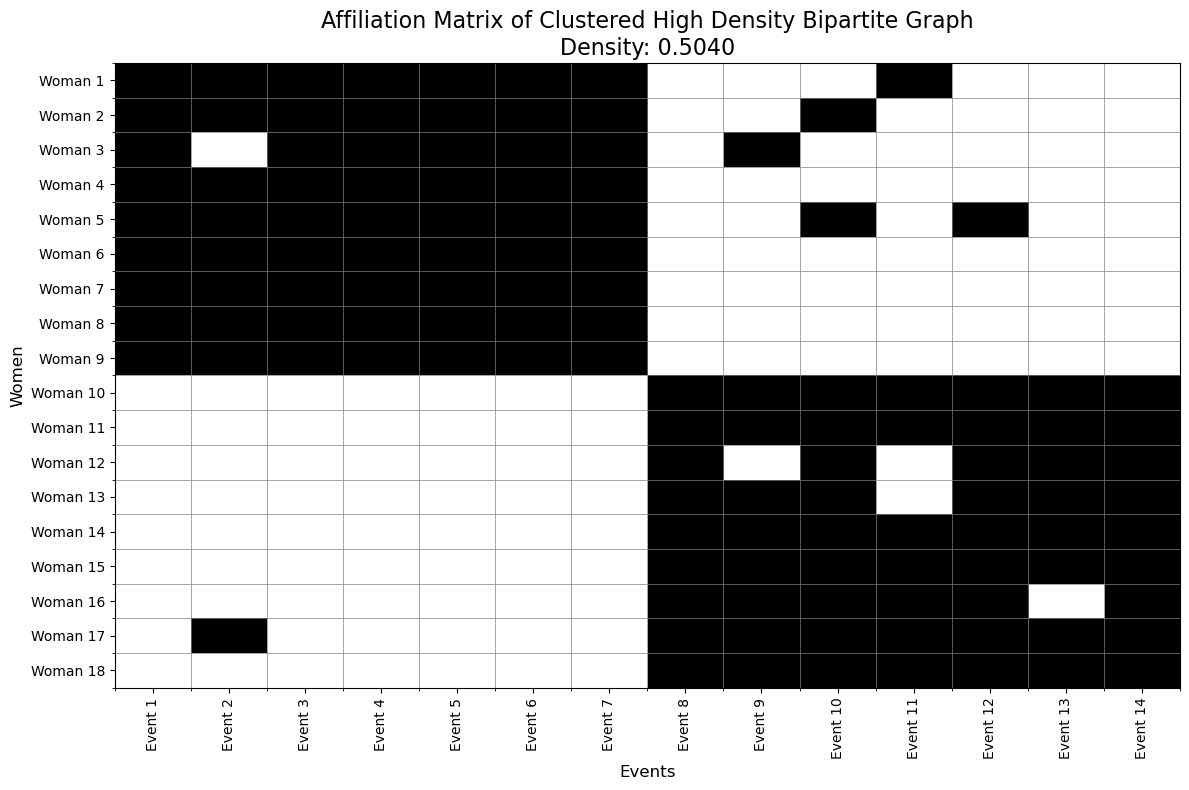

Actual density: 0.5040


In [9]:
def generate_clustered_high_density_bipartite(n_top, n_bottom, intra_cluster_density=0.95, inter_cluster_density=0.05):
    G = nx.Graph()
    G.add_nodes_from(range(n_top), bipartite=0)
    G.add_nodes_from(range(n_top, n_top + n_bottom), bipartite=1)
    
    # Split nodes into two clusters
    top_split = n_top // 2
    bottom_split = n_bottom // 2
    
    # Connect nodes within clusters with high density
    for i in range(top_split):
        for j in range(n_top, n_top + bottom_split):
            if random.random() < intra_cluster_density:
                G.add_edge(i, j)
    
    for i in range(top_split, n_top):
        for j in range(n_top + bottom_split, n_top + n_bottom):
            if random.random() < intra_cluster_density:
                G.add_edge(i, j)
    
    # Connect nodes between clusters with low density
    for i in range(top_split):
        for j in range(n_top + bottom_split, n_top + n_bottom):
            if random.random() < inter_cluster_density:
                G.add_edge(i, j)
    
    for i in range(top_split, n_top):
        for j in range(n_top, n_top + bottom_split):
            if random.random() < inter_cluster_density:
                G.add_edge(i, j)
    
    return G

def plot_bipartite_matrix(G, filename):
    top_nodes = sorted([n for n, d in G.nodes(data=True) if d['bipartite'] == 0])
    bottom_nodes = sorted([n for n, d in G.nodes(data=True) if d['bipartite'] == 1])
    
    affiliation_matrix = nx.bipartite.biadjacency_matrix(G, row_order=top_nodes, column_order=bottom_nodes).todense()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(affiliation_matrix, cmap='gray_r', interpolation='nearest', aspect='auto')
    
    ax.set_xticks(np.arange(len(bottom_nodes)))
    ax.set_yticks(np.arange(len(top_nodes)))
    
    ax.set_xticklabels([f'Event {i+1}' for i in range(len(bottom_nodes))], rotation=90)
    ax.set_yticklabels([f'Woman {i+1}' for i in range(len(top_nodes))])
    
    ax.set_xlabel('Events', fontsize=12)
    ax.set_ylabel('Women', fontsize=12)
    
    plt.title(f"Affiliation Matrix of Clustered High Density Bipartite Graph\nDensity: {nx.bipartite.density(G, top_nodes):.4f}", fontsize=16)
    
    ax.set_xticks(np.arange(affiliation_matrix.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(affiliation_matrix.shape[0]+1)-.5, minor=True)
    
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=0.5)
    ax.grid(which="major", visible=False)
    
    plt.tight_layout()
    # plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Generate and plot a clustered high density bipartite graph
n_women = 18  # Same as in Davis Southern Women graph
n_events = 14  # Same as in Davis Southern Women graph
clustered_high_density_graph = generate_clustered_high_density_bipartite(n_women, n_events, intra_cluster_density=0.95, inter_cluster_density=0.05)

plot_bipartite_matrix(clustered_high_density_graph, 'figures/clustered_high_density_bipartite_matrix.png')

# Print the actual density
top_nodes = [n for n, d in clustered_high_density_graph.nodes(data=True) if d['bipartite'] == 0]
print(f"Actual density: {nx.bipartite.density(clustered_high_density_graph, top_nodes):.4f}")

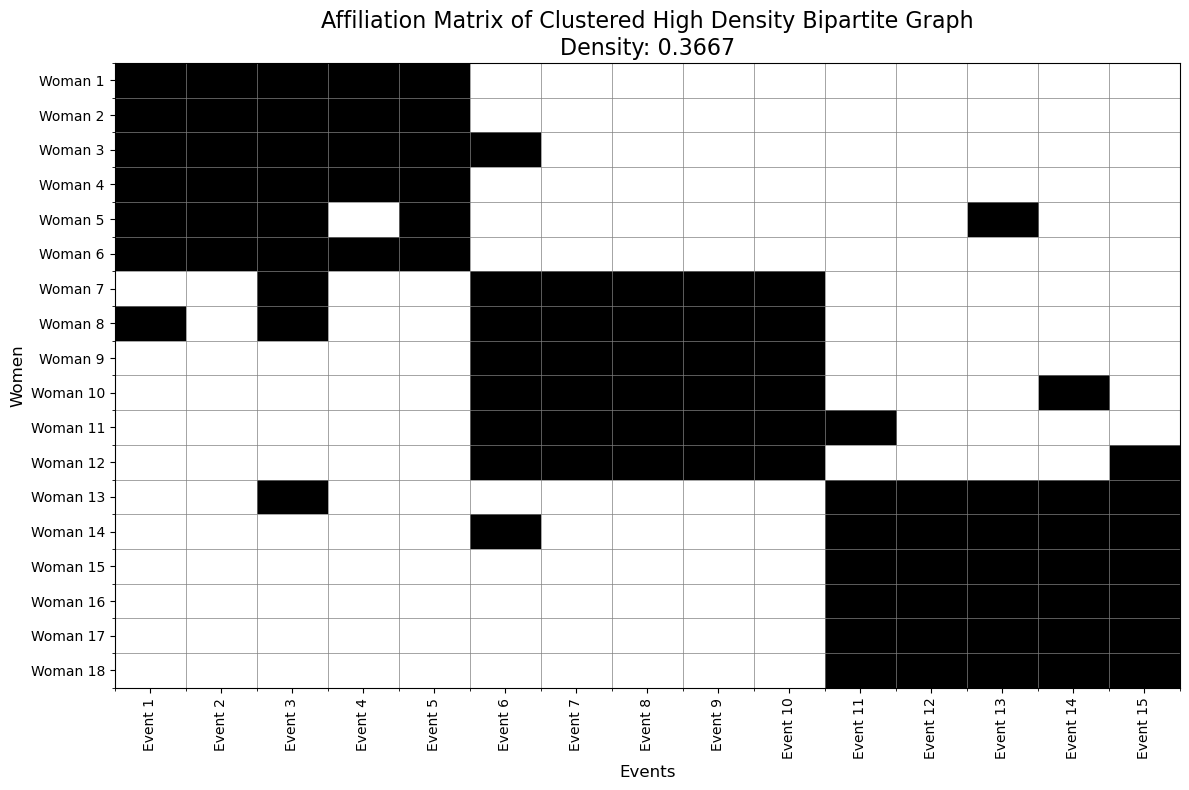

Actual density: 0.3667


In [10]:
def generate_three_cluster_high_density_bipartite(n_top, n_bottom, intra_cluster_density=0.95, inter_cluster_density=0.05):
    G = nx.Graph()
    G.add_nodes_from(range(n_top), bipartite=0)
    G.add_nodes_from(range(n_top, n_top + n_bottom), bipartite=1)
    
    # Split nodes into three clusters
    top_split1 = n_top // 3
    top_split2 = 2 * n_top // 3
    bottom_split1 = n_bottom // 3
    bottom_split2 = 2 * n_bottom // 3
    
    # Connect nodes within clusters with high density
    cluster_ranges = [
        (range(top_split1), range(n_top, n_top + bottom_split1)),
        (range(top_split1, top_split2), range(n_top + bottom_split1, n_top + bottom_split2)),
        (range(top_split2, n_top), range(n_top + bottom_split2, n_top + n_bottom))
    ]
    
    for top_range, bottom_range in cluster_ranges:
        for i in top_range:
            for j in bottom_range:
                if random.random() < intra_cluster_density:
                    G.add_edge(i, j)
    
    # Connect nodes between clusters with low density
    for i in range(n_top):
        for j in range(n_top, n_top + n_bottom):
            if (i // top_split1) != ((j - n_top) // bottom_split1):  # If nodes are in different clusters
                if random.random() < inter_cluster_density:
                    G.add_edge(i, j)
    
    return G
# Generate and plot a three-clustered high density bipartite graph
n_women = 18  # Same as in Davis Southern Women graph
n_events = 15  # Adjusted to be divisible by 3
three_clustered_high_density_graph = generate_three_cluster_high_density_bipartite(n_women, n_events, intra_cluster_density=0.95, inter_cluster_density=0.05)

plot_bipartite_matrix(three_clustered_high_density_graph, 'figures/three_clustered_high_density_bipartite_matrix.png')

# Print the actual density
top_nodes = [n for n, d in three_clustered_high_density_graph.nodes(data=True) if d['bipartite'] == 0]
print(f"Actual density: {nx.bipartite.density(three_clustered_high_density_graph, top_nodes):.4f}")

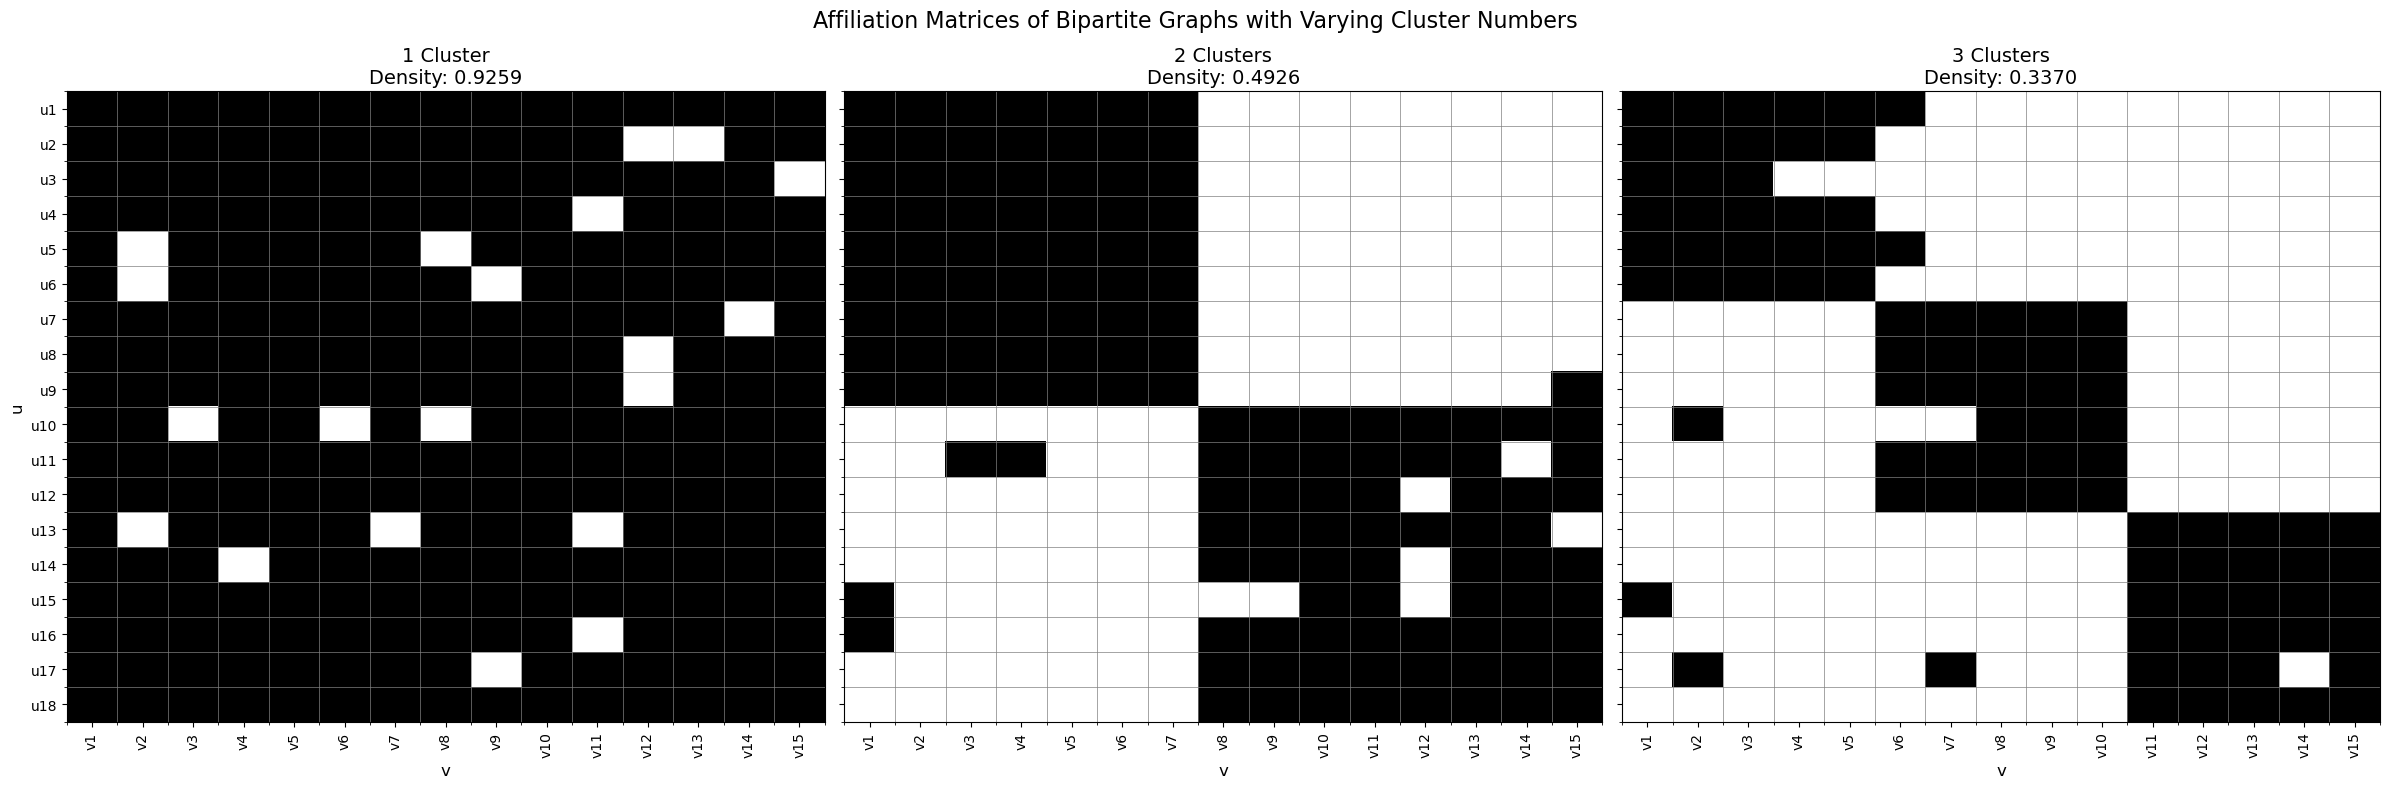

Graph 1 actual density: 0.9259
Graph 2 actual density: 0.4926
Graph 3 actual density: 0.3370


In [12]:
def plot_bipartite_matrices(graphs, num_clusters):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle("Affiliation Matrices of Bipartite Graphs with Varying Cluster Numbers", fontsize=16)

    for i, (G, ax, clusters) in enumerate(zip(graphs, axes, num_clusters)):
        top_nodes = sorted([n for n, d in G.nodes(data=True) if d['bipartite'] == 0])
        bottom_nodes = sorted([n for n, d in G.nodes(data=True) if d['bipartite'] == 1])
        
        affiliation_matrix = nx.bipartite.biadjacency_matrix(G, row_order=top_nodes, column_order=bottom_nodes).todense()
        
        im = ax.imshow(affiliation_matrix, cmap='gray_r', interpolation='nearest', aspect='auto')
        
        ax.set_xticks(np.arange(len(bottom_nodes)))
        ax.set_yticks(np.arange(len(top_nodes)))
        
        ax.set_xticklabels([f'v{i+1}' for i in range(len(bottom_nodes))], rotation=90)
        if i == 0:  # Only set y-axis labels for the leftmost plot
            ax.set_yticklabels([f'u{i+1}' for i in range(len(top_nodes))])
        else:
            ax.set_yticklabels([])
        
        ax.set_xlabel('v', fontsize=12)
        if i == 0:
            ax.set_ylabel('u', fontsize=12)
        
        ax.set_title(f"{clusters} Cluster{'s' if clusters > 1 else ''}\nDensity: {nx.bipartite.density(G, top_nodes):.4f}", fontsize=14)
        
        ax.set_xticks(np.arange(affiliation_matrix.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(affiliation_matrix.shape[0]+1)-.5, minor=True)
        
        ax.grid(which="minor", color="grey", linestyle='-', linewidth=0.5)
        ax.grid(which="major", visible=False)

    plt.tight_layout()
    plt.savefig('figures/bipartite_matrices_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate graphs
n_top = 18
n_bottom = 15  # Using 15 for all to make them consistent

high_density_graph = generate_high_density_bipartite(n_top, n_bottom, density=0.95)
clustered_high_density_graph = generate_clustered_high_density_bipartite(n_top, n_bottom, intra_cluster_density=0.95, inter_cluster_density=0.05)
three_clustered_high_density_graph = generate_three_cluster_high_density_bipartite(n_top, n_bottom, intra_cluster_density=0.95, inter_cluster_density=0.05)

# Plot all three graphs
graphs = [high_density_graph, clustered_high_density_graph, three_clustered_high_density_graph]
num_clusters = [1, 2, 3]
plot_bipartite_matrices(graphs, num_clusters)

# Print the actual densities
for i, G in enumerate(graphs):
    top_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
    print(f"Graph {i+1} actual density: {nx.bipartite.density(G, top_nodes):.4f}")

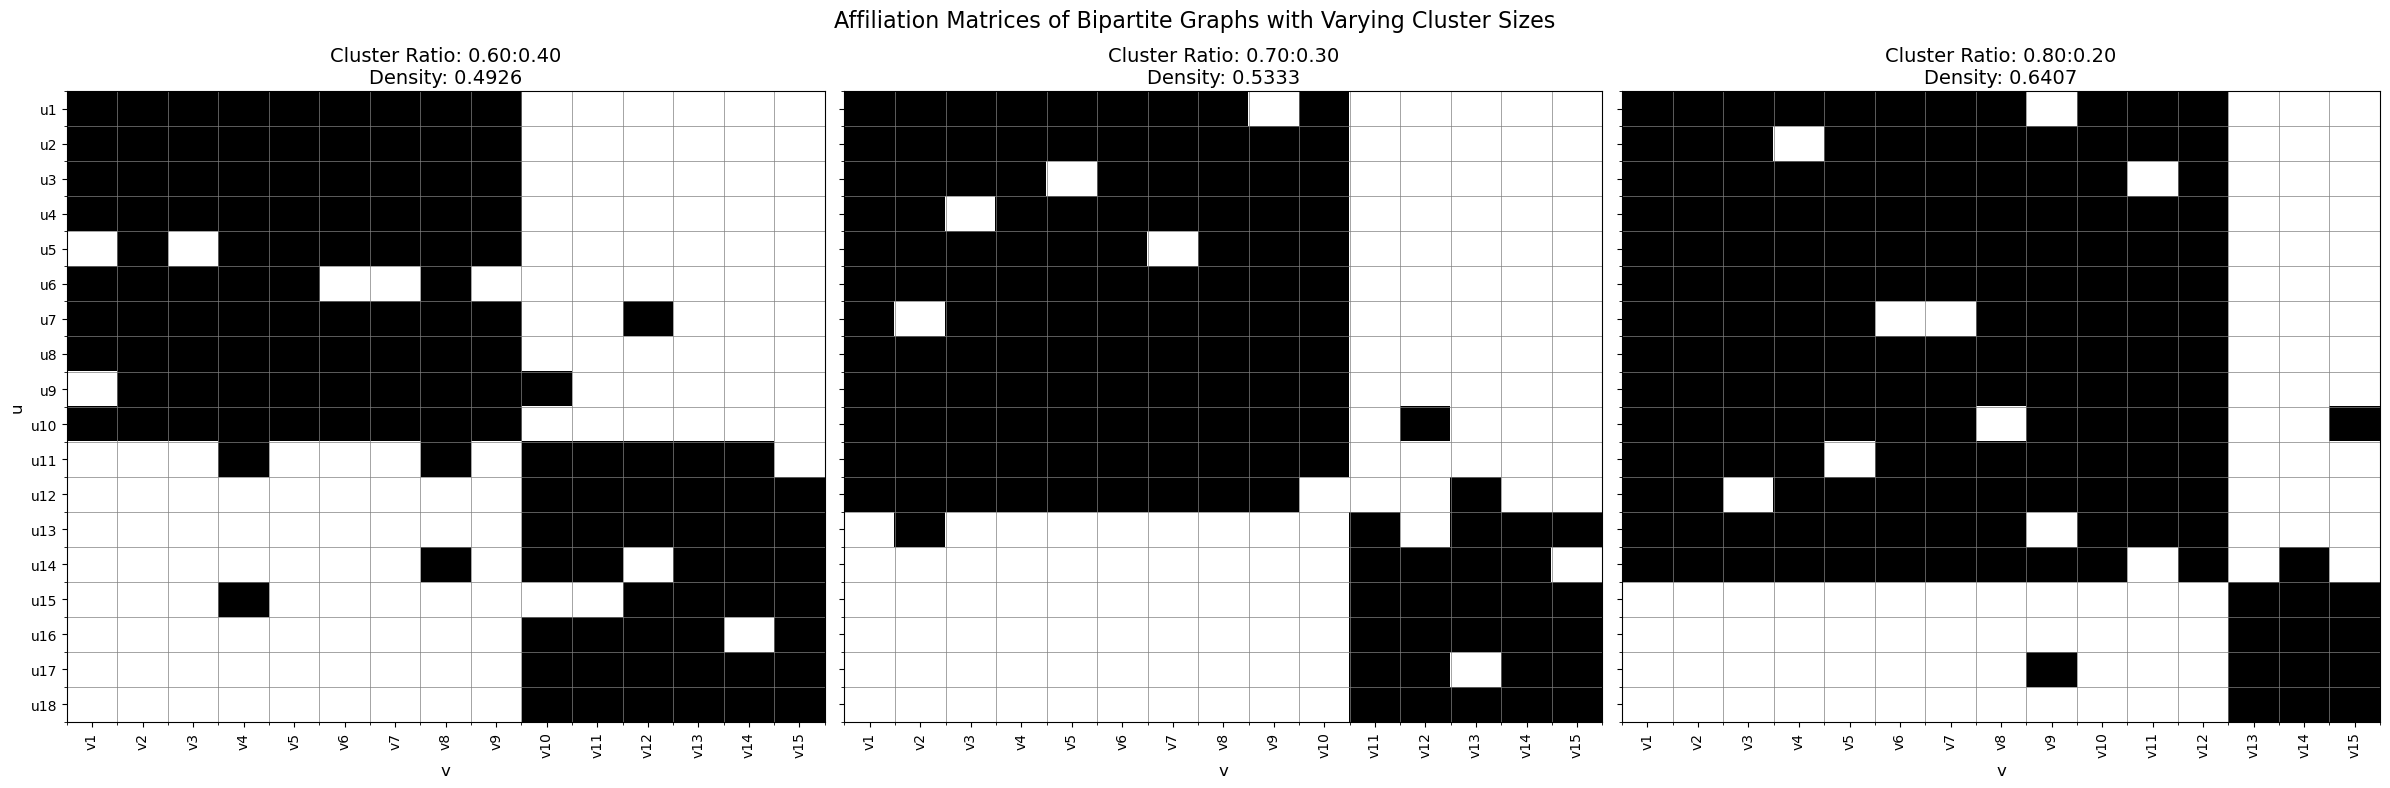

Graph 1 (Ratio 0.60:0.40):
  Actual density: 0.4926
  Theoretical bound: 0.5200
Graph 2 (Ratio 0.70:0.30):
  Actual density: 0.5333
  Theoretical bound: 0.5800
Graph 3 (Ratio 0.80:0.20):
  Actual density: 0.6407
  Theoretical bound: 0.6800


In [13]:
def generate_two_cluster_bipartite(n_top, n_bottom, cluster_ratio, intra_cluster_density=0.95, inter_cluster_density=0.05):
    G = nx.Graph()
    G.add_nodes_from(range(n_top), bipartite=0)
    G.add_nodes_from(range(n_top, n_top + n_bottom), bipartite=1)
    
    top_split = int(n_top * cluster_ratio)
    bottom_split = int(n_bottom * cluster_ratio)
    
    # Connect nodes within clusters with high density
    for i in range(top_split):
        for j in range(n_top, n_top + bottom_split):
            if random.random() < intra_cluster_density:
                G.add_edge(i, j)
    
    for i in range(top_split, n_top):
        for j in range(n_top + bottom_split, n_top + n_bottom):
            if random.random() < intra_cluster_density:
                G.add_edge(i, j)
    
    # Connect nodes between clusters with low density
    for i in range(top_split):
        for j in range(n_top + bottom_split, n_top + n_bottom):
            if random.random() < inter_cluster_density:
                G.add_edge(i, j)
    
    for i in range(top_split, n_top):
        for j in range(n_top, n_top + bottom_split):
            if random.random() < inter_cluster_density:
                G.add_edge(i, j)
    
    return G

def plot_bipartite_matrices(graphs, cluster_ratios):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle("Affiliation Matrices of Bipartite Graphs with Varying Cluster Sizes", fontsize=16)

    for i, (G, ax, ratio) in enumerate(zip(graphs, axes, cluster_ratios)):
        top_nodes = sorted([n for n, d in G.nodes(data=True) if d['bipartite'] == 0])
        bottom_nodes = sorted([n for n, d in G.nodes(data=True) if d['bipartite'] == 1])
        
        affiliation_matrix = nx.bipartite.biadjacency_matrix(G, row_order=top_nodes, column_order=bottom_nodes).todense()
        
        im = ax.imshow(affiliation_matrix, cmap='gray_r', interpolation='nearest', aspect='auto')
        
        ax.set_xticks(np.arange(len(bottom_nodes)))
        ax.set_yticks(np.arange(len(top_nodes)))
        
        ax.set_xticklabels([f'v{i+1}' for i in range(len(bottom_nodes))], rotation=90)
        if i == 0:  # Only set y-axis labels for the leftmost plot
            ax.set_yticklabels([f'u{i+1}' for i in range(len(top_nodes))])
        else:
            ax.set_yticklabels([])
        
        ax.set_xlabel('v', fontsize=12)
        if i == 0:
            ax.set_ylabel('u', fontsize=12)
        
        density = nx.bipartite.density(G, top_nodes)
        ax.set_title(f"Cluster Ratio: {ratio:.2f}:{1-ratio:.2f}\nDensity: {density:.4f}", fontsize=14)
        
        ax.set_xticks(np.arange(affiliation_matrix.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(affiliation_matrix.shape[0]+1)-.5, minor=True)
        
        ax.grid(which="minor", color="grey", linestyle='-', linewidth=0.5)
        ax.grid(which="major", visible=False)

    plt.tight_layout()
    # plt.savefig('figures/bipartite_matrices_unequal_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate graphs
n_top = 18
n_bottom = 15
cluster_ratios = [0.6, 0.7, 0.8]  # Ratios for the size of the first cluster
graphs = [generate_two_cluster_bipartite(n_top, n_bottom, ratio) for ratio in cluster_ratios]

# Plot all three graphs
plot_bipartite_matrices(graphs, cluster_ratios)

# Print the actual densities and theoretical bounds
for i, (G, ratio) in enumerate(zip(graphs, cluster_ratios)):
    top_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
    actual_density = nx.bipartite.density(G, top_nodes)
    theoretical_bound = ratio**2 + (1-ratio)**2
    print(f"Graph {i+1} (Ratio {ratio:.2f}:{1-ratio:.2f}):")
    print(f"  Actual density: {actual_density:.4f}")
    print(f"  Theoretical bound: {theoretical_bound:.4f}")

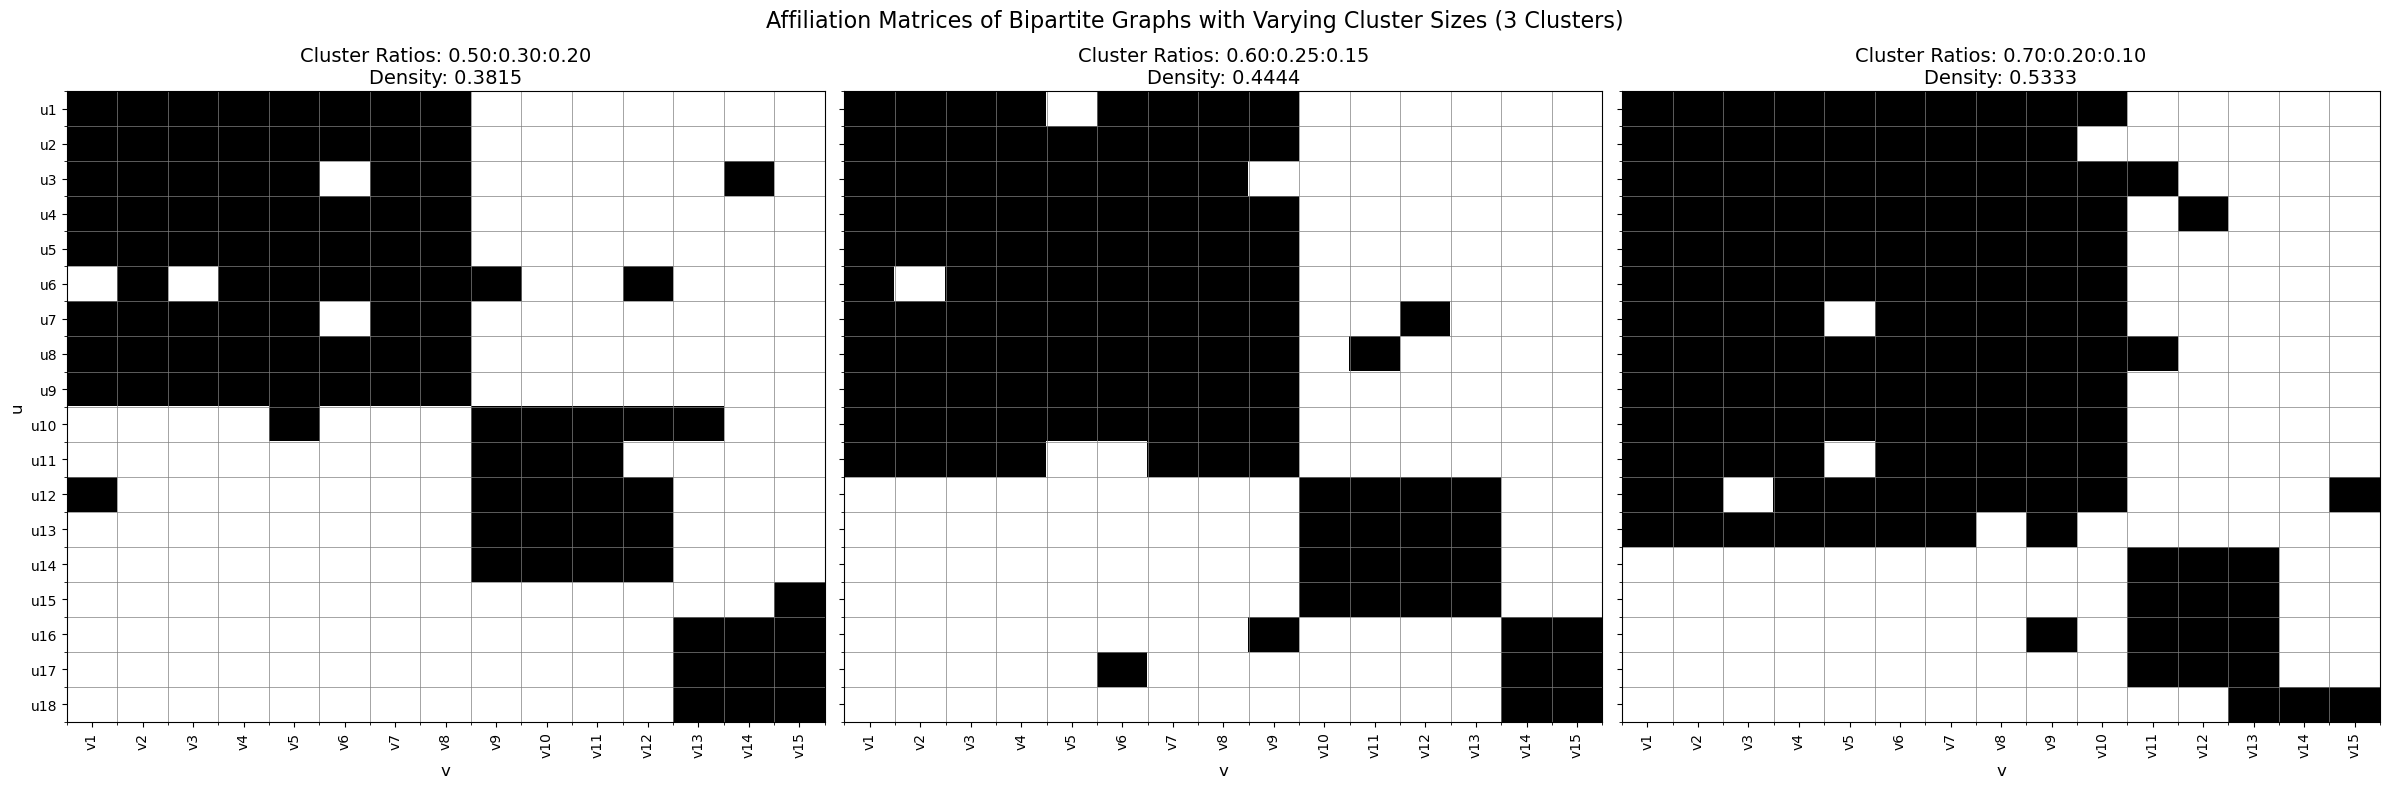

Graph 1 (Ratios 0.50:0.30:0.20):
  Actual density: 0.3815
  Theoretical bound: 0.3800
Graph 2 (Ratios 0.60:0.25:0.15):
  Actual density: 0.4444
  Theoretical bound: 0.4450
Graph 3 (Ratios 0.70:0.20:0.10):
  Actual density: 0.5333
  Theoretical bound: 0.5400


In [16]:
def generate_three_cluster_bipartite(n_top, n_bottom, cluster_ratios, intra_cluster_density=0.95, inter_cluster_density=0.05):
    G = nx.Graph()
    G.add_nodes_from(range(n_top), bipartite=0)
    G.add_nodes_from(range(n_top, n_top + n_bottom), bipartite=1)
    
    top_splits = [round(n_top * ratio) for ratio in cluster_ratios]
    bottom_splits = [round(n_bottom * ratio) for ratio in cluster_ratios]
    
    # Adjust the last split to ensure all nodes are included
    top_splits[-1] = n_top - sum(top_splits[:-1])
    bottom_splits[-1] = n_bottom - sum(bottom_splits[:-1])
    
    top_cumulative = [sum(top_splits[:i]) for i in range(len(top_splits) + 1)]
    bottom_cumulative = [n_top + sum(bottom_splits[:i]) for i in range(len(bottom_splits) + 1)]
    
    # Connect nodes within clusters with high density
    for cluster in range(3):
        for i in range(top_cumulative[cluster], top_cumulative[cluster+1]):
            for j in range(bottom_cumulative[cluster], bottom_cumulative[cluster+1]):
                if random.random() < intra_cluster_density:
                    G.add_edge(i, j)
    
    # Connect nodes between clusters with low density
    for cluster1 in range(3):
        for cluster2 in range(cluster1 + 1, 3):
            for i in range(top_cumulative[cluster1], top_cumulative[cluster1+1]):
                for j in range(bottom_cumulative[cluster2], bottom_cumulative[cluster2+1]):
                    if random.random() < inter_cluster_density:
                        G.add_edge(i, j)
            for i in range(top_cumulative[cluster2], top_cumulative[cluster2+1]):
                for j in range(bottom_cumulative[cluster1], bottom_cumulative[cluster1+1]):
                    if random.random() < inter_cluster_density:
                        G.add_edge(i, j)
    
    return G

def plot_bipartite_matrices(graphs, cluster_ratios_list):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle("Affiliation Matrices of Bipartite Graphs with Varying Cluster Sizes (3 Clusters)", fontsize=16)

    for i, (G, ax, ratios) in enumerate(zip(graphs, axes, cluster_ratios_list)):
        top_nodes = sorted([n for n, d in G.nodes(data=True) if d['bipartite'] == 0])
        bottom_nodes = sorted([n for n, d in G.nodes(data=True) if d['bipartite'] == 1])
        
        affiliation_matrix = nx.bipartite.biadjacency_matrix(G, row_order=top_nodes, column_order=bottom_nodes).todense()
        
        im = ax.imshow(affiliation_matrix, cmap='gray_r', interpolation='nearest', aspect='auto')
        
        ax.set_xticks(np.arange(len(bottom_nodes)))
        ax.set_yticks(np.arange(len(top_nodes)))
        
        ax.set_xticklabels([f'v{i+1}' for i in range(len(bottom_nodes))], rotation=90)
        if i == 0:  # Only set y-axis labels for the leftmost plot
            ax.set_yticklabels([f'u{i+1}' for i in range(len(top_nodes))])
        else:
            ax.set_yticklabels([])
        
        ax.set_xlabel('v', fontsize=12)
        if i == 0:
            ax.set_ylabel('u', fontsize=12)
        
        density = nx.bipartite.density(G, top_nodes)
        ratio_str = ':'.join([f'{r:.2f}' for r in ratios])
        ax.set_title(f"Cluster Ratios: {ratio_str}\nDensity: {density:.4f}", fontsize=14)
        
        ax.set_xticks(np.arange(affiliation_matrix.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(affiliation_matrix.shape[0]+1)-.5, minor=True)
        
        ax.grid(which="minor", color="grey", linestyle='-', linewidth=0.5)
        ax.grid(which="major", visible=False)

    plt.tight_layout()
    # plt.savefig('figures/bipartite_matrices_unequal_three_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate graphs
n_top = 18
n_bottom = 15
cluster_ratios_list = [
    [0.5, 0.3, 0.2],
    [0.6, 0.25, 0.15],
    [0.7, 0.2, 0.1]
]
graphs = [generate_three_cluster_bipartite(n_top, n_bottom, ratios) for ratios in cluster_ratios_list]

# Plot all three graphs
plot_bipartite_matrices(graphs, cluster_ratios_list)

# Print the actual densities and theoretical bounds
for i, (G, ratios) in enumerate(zip(graphs, cluster_ratios_list)):
    top_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
    actual_density = nx.bipartite.density(G, top_nodes)
    theoretical_bound = sum(r**2 for r in ratios)
    print(f"Graph {i+1} (Ratios {':'.join([f'{r:.2f}' for r in ratios])}):")
    print(f"  Actual density: {actual_density:.4f}")
    print(f"  Theoretical bound: {theoretical_bound:.4f}")

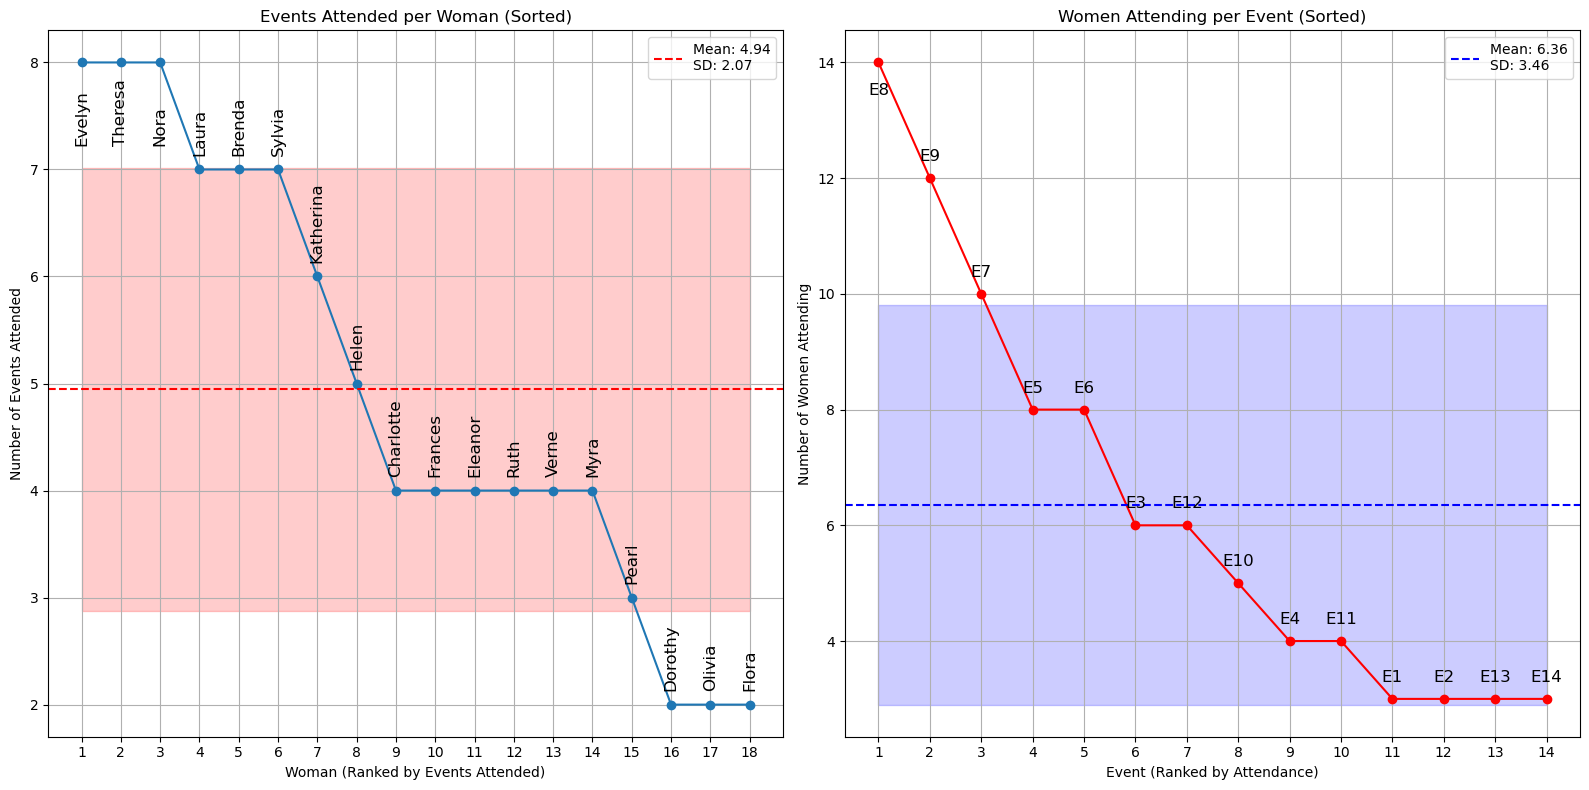

In [4]:
# Separate the nodes into the two partitions
women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
events = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

# Calculate degrees and sort
women_degrees = sorted([(woman, G.degree(woman)) for woman in women], key=lambda x: x[1], reverse=True)
event_degrees = sorted([(event, G.degree(event)) for event in events], key=lambda x: x[1], reverse=True)

# Calculate mean and standard deviation of degrees
women_degrees_values = [d for _, d in women_degrees]
event_degrees_values = [d for _, d in event_degrees]

women_mean_degree = np.mean(women_degrees_values)
women_std_degree = np.std(women_degrees_values)
event_mean_degree = np.mean(event_degrees_values)
event_std_degree = np.std(event_degrees_values)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot for women
ax1.plot(range(1, len(women) + 1), women_degrees_values, marker='o')
ax1.axhline(y=women_mean_degree, color='r', linestyle='--', 
            label=f'Mean: {women_mean_degree:.2f}\nSD: {women_std_degree:.2f}')
ax1.fill_between(range(1, len(women) + 1), 
                 women_mean_degree - women_std_degree, 
                 women_mean_degree + women_std_degree, 
                 alpha=0.2, color='r')
ax1.set_xlabel('Woman (Ranked by Events Attended)', fontsize=10)
ax1.set_ylabel('Number of Events Attended', fontsize=10)
ax1.set_title('Events Attended per Woman (Sorted)', fontsize=12)
ax1.set_xticks(range(1, len(women) + 1))
ax1.grid(True)
ax1.legend()

# Add rotated labels for each point in the women plot
for i, (woman, degree) in enumerate(women_degrees):
    if i < 3:
        va_temp = 'top'
        y_offset = -60
    else:
        va_temp = 'bottom'
        y_offset = 10
    ax1.annotate(f"{woman.split()[0]}", (i+1, degree), textcoords="offset points", 
                 xytext=(0, y_offset), ha='center', va='bottom', rotation=90, fontsize=12)

# Plot for events
ax2.plot(range(1, len(events) + 1), event_degrees_values, marker='o', color='red')
ax2.axhline(y=event_mean_degree, color='b', linestyle='--', 
            label=f'Mean: {event_mean_degree:.2f}\nSD: {event_std_degree:.2f}')
ax2.fill_between(range(1, len(events) + 1), 
                 event_mean_degree - event_std_degree, 
                 event_mean_degree + event_std_degree, 
                 alpha=0.2, color='b')
ax2.set_xlabel('Event (Ranked by Attendance)', fontsize=10)
ax2.set_ylabel('Number of Women Attending', fontsize=10)
ax2.set_title('Women Attending per Event (Sorted)', fontsize=12)
ax2.set_xticks(range(1, len(events) + 1))
ax2.grid(True)
ax2.legend()

# Add rotated labels for each point in the events plot
for i, (event, degree) in enumerate(event_degrees):
    if i < 1:
        va_temp = 'top'
        y_offset = -15
    else:
        va_temp = 'bottom'
        y_offset = 10
    
    ax2.annotate(f"{event}", (i+1, degree), textcoords="offset points", 
                 xytext=(0,y_offset), ha='center', va=va_temp, rotation=0, fontsize=12)

plt.tight_layout()
plt.savefig('figures/events_attending.png', dpi=300, bbox_inches='tight')

plt.show()



LaTeX table has been saved to 'tables/comparison_clustering.tex'
             Network  Nodes  Links  Non-backtracking  Louvain  Newman  Modularity eigengap
Davis Southern Women     32     89                 2        4       2                   31


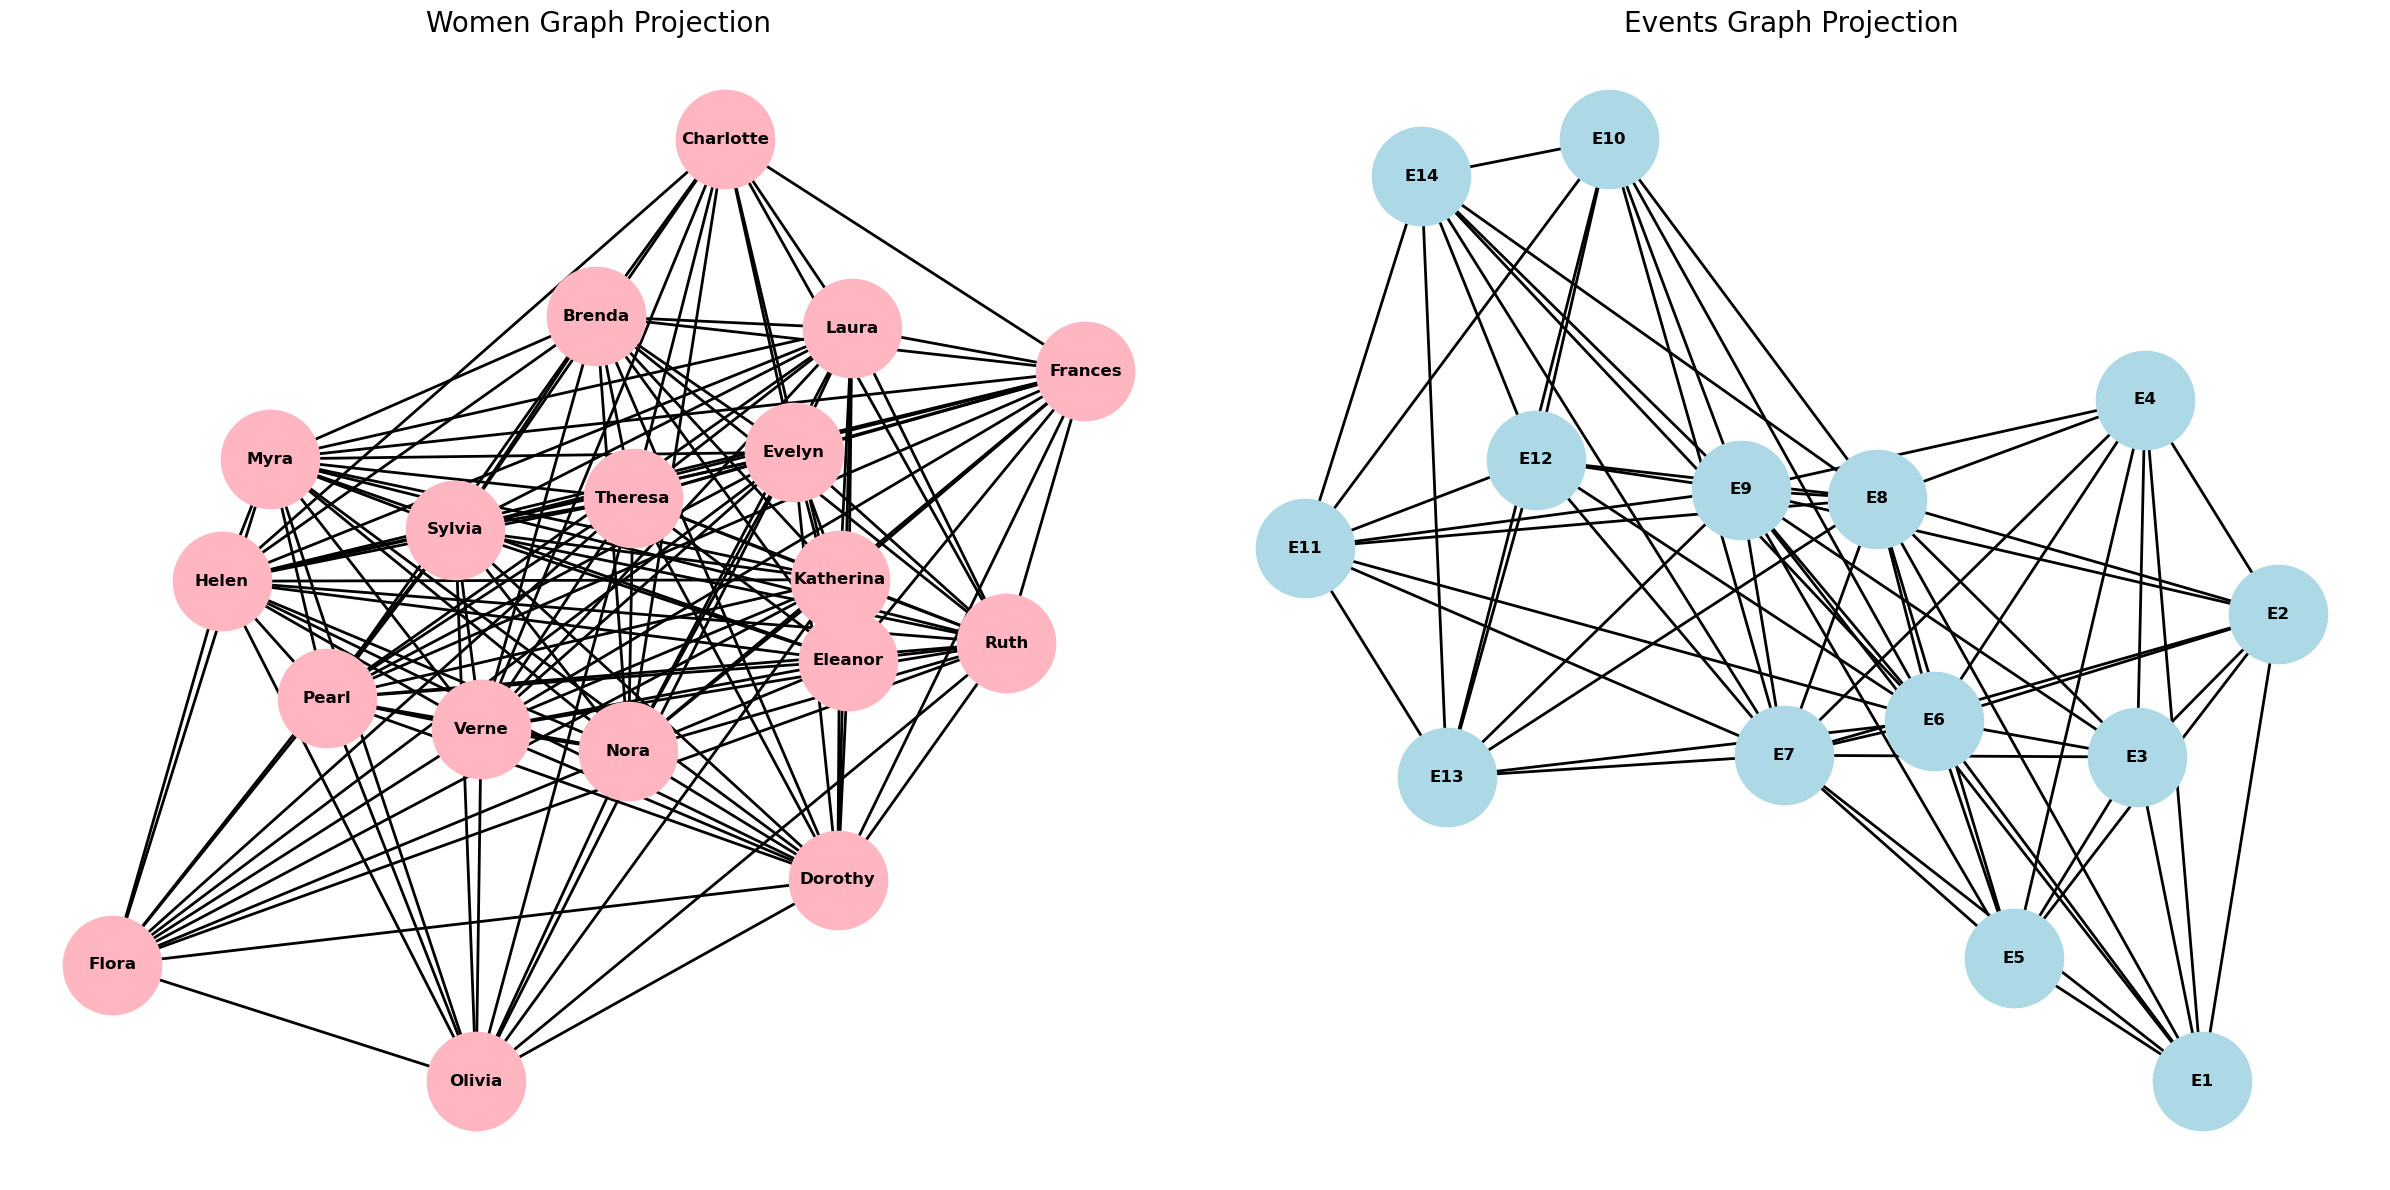

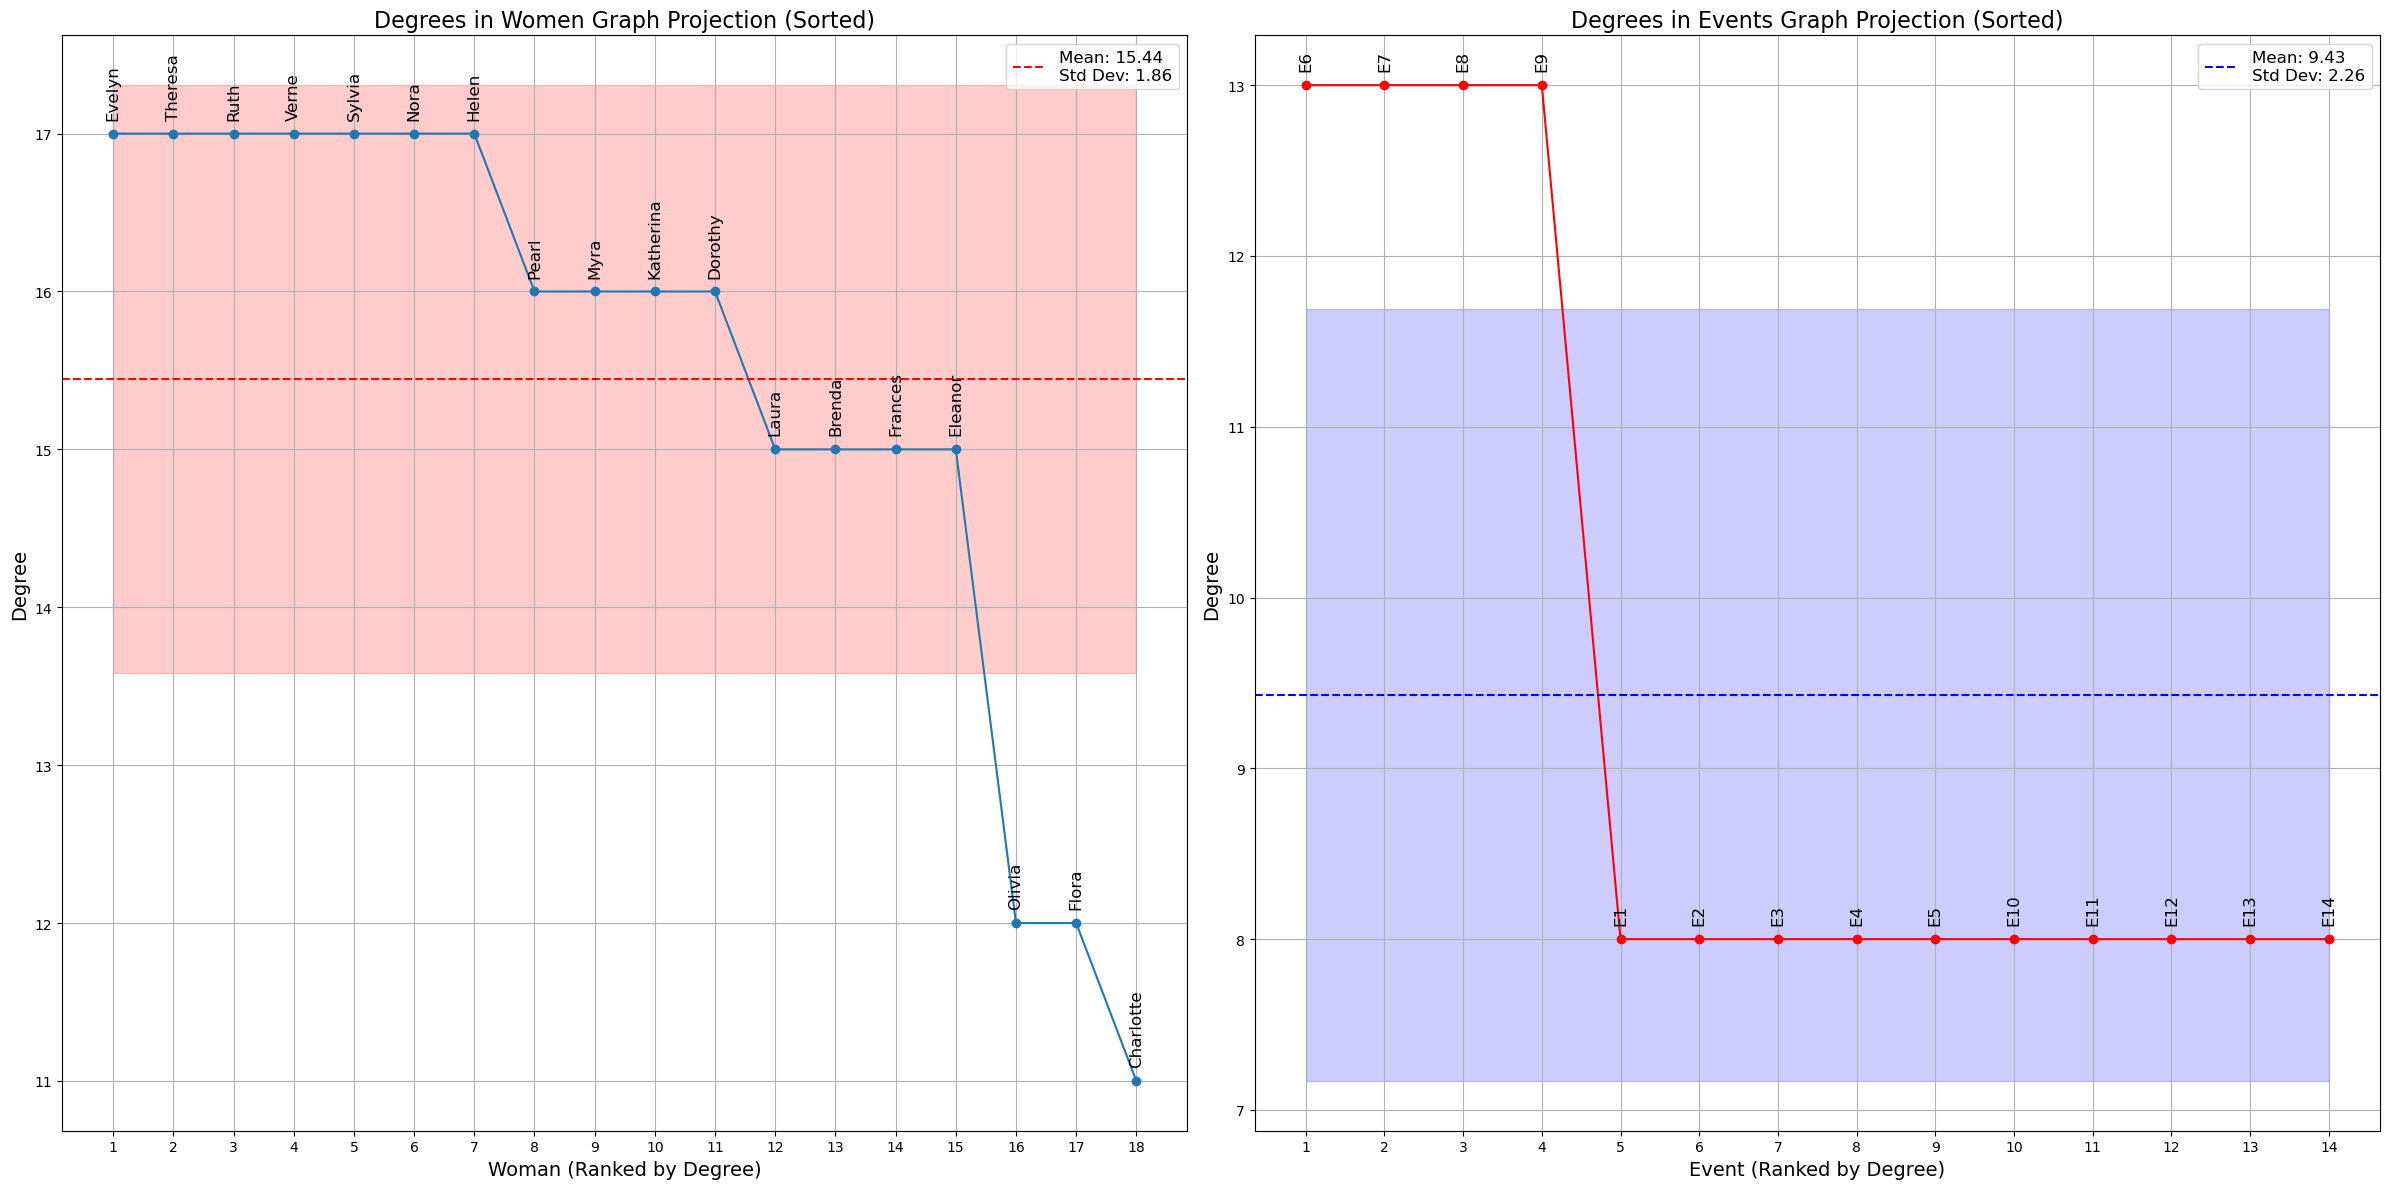

Women Graph: 18 nodes, 139 edges
Events Graph: 14 nodes, 66 edges

Women Graph Edge Weights (Top 5):
Evelyn - Theresa: 7
Evelyn - Laura: 6
Evelyn - Brenda: 6
Laura - Theresa: 6
Laura - Brenda: 6

Events Graph Edge Weights (Top 5):
Event E8 - Event E9: 9
Event E7 - Event E8: 8
Event E5 - Event E8: 7
Event E6 - Event E8: 7
Event E3 - Event E5: 6


In [3]:
# Separate the nodes into the two partitions
women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
events = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

# Create the projections with weights
women_graph = nx.bipartite.weighted_projected_graph(G, women)
events_graph = nx.bipartite.weighted_projected_graph(G, events)

# Calculate degrees and sort
women_degrees = sorted([(woman, women_graph.degree(woman)) for woman in women_graph.nodes()], key=lambda x: x[1], reverse=True)
event_degrees = sorted([(event, events_graph.degree(event)) for event in events_graph.nodes()], key=lambda x: x[1], reverse=True)

# Calculate mean and standard deviation of degrees
women_degrees_values = [d for _, d in women_degrees]
event_degrees_values = [d for _, d in event_degrees]

women_mean_degree = np.mean(women_degrees_values)
women_std_degree = np.std(women_degrees_values)
event_mean_degree = np.mean(event_degrees_values)
event_std_degree = np.std(event_degrees_values)

# Figure 1: Graph Projections
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

# Plot women graph
pos_women = nx.spring_layout(women_graph, k=0.5, iterations=50)
nx.draw(women_graph, pos_women, ax=ax1, with_labels=False, node_color='lightpink', 
        node_size=5000, width=2)
labels = {node: node.split()[0] for node in women_graph.nodes()}
nx.draw_networkx_labels(women_graph, pos_women, labels, ax=ax1, font_size=12, font_weight='bold')
ax1.set_title("Women Graph Projection", fontsize=20)

# Plot events graph
pos_events = nx.spring_layout(events_graph, k=0.5, iterations=50)
nx.draw(events_graph, pos_events, ax=ax2, with_labels=True, node_color='lightblue', 
        node_size=5000, font_size=12, font_weight='bold', width=2)
ax2.set_title("Events Graph Projection", fontsize=20)

plt.tight_layout()
plt.savefig('figures/bipartite_projection.png', dpi=300, bbox_inches='tight')

plt.show()



# Figure 2: Degree Distributions
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(24, 12))

# Plot for women degrees
ax3.plot(range(1, len(women_degrees) + 1), women_degrees_values, marker='o')
ax3.axhline(y=women_mean_degree, color='r', linestyle='--', 
            label=f'Mean: {women_mean_degree:.2f}\nStd Dev: {women_std_degree:.2f}')
ax3.fill_between(range(1, len(women_degrees) + 1), 
                 women_mean_degree - women_std_degree, 
                 women_mean_degree + women_std_degree, 
                 alpha=0.2, color='r')
ax3.set_xlabel('Woman (Ranked by Degree)', fontsize=14)
ax3.set_ylabel('Degree', fontsize=14)
ax3.set_title('Degrees in Women Graph Projection (Sorted)', fontsize=16)
ax3.set_xticks(range(1, len(women_degrees) + 1))
ax3.grid(True)
ax3.legend(fontsize=12)

# Add rotated labels for each point in the women degree plot
for i, (woman, degree) in enumerate(women_degrees):
    ax3.annotate(f"{woman.split()[0]}", (i+1, degree), textcoords="offset points", 
                 xytext=(0, 10), ha='center', va='bottom', rotation=90, fontsize=12)

# Plot for events degrees
ax4.plot(range(1, len(event_degrees) + 1), event_degrees_values, marker='o', color='red')
ax4.axhline(y=event_mean_degree, color='b', linestyle='--', 
            label=f'Mean: {event_mean_degree:.2f}\nStd Dev: {event_std_degree:.2f}')
ax4.fill_between(range(1, len(event_degrees) + 1), 
                 event_mean_degree - event_std_degree, 
                 event_mean_degree + event_std_degree, 
                 alpha=0.2, color='b')
ax4.set_xlabel('Event (Ranked by Degree)', fontsize=14)
ax4.set_ylabel('Degree', fontsize=14)
ax4.set_title('Degrees in Events Graph Projection (Sorted)', fontsize=16)
ax4.set_xticks(range(1, len(event_degrees) + 1))
ax4.grid(True)
ax4.legend(fontsize=12)

# Add rotated labels for each point in the events degree plot
for i, (event, degree) in enumerate(event_degrees):
    ax4.annotate(f"{event}", (i+1, degree), textcoords="offset points", 
                 xytext=(0, 10), ha='center', va='bottom', rotation=90, fontsize=12)

plt.tight_layout()
plt.savefig('figures/bipartite_projection_degrees.png', dpi=300, bbox_inches='tight')
plt.show()



# Print some basic information about the projections
print(f"Women Graph: {women_graph.number_of_nodes()} nodes, {women_graph.number_of_edges()} edges")
print(f"Events Graph: {events_graph.number_of_nodes()} nodes, {events_graph.number_of_edges()} edges")

# Print edge weights for women graph
print("\nWomen Graph Edge Weights (Top 5):")
women_edges = sorted(women_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
for edge in women_edges:
    print(f"{edge[0].split()[0]} - {edge[1].split()[0]}: {edge[2]['weight']}")

# Print edge weights for events graph
print("\nEvents Graph Edge Weights (Top 5):")
event_edges = sorted(events_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
for edge in event_edges:
    print(f"Event {edge[0]} - Event {edge[1]}: {edge[2]['weight']}")

In [6]:
### Centrality measure, which vertex are import 

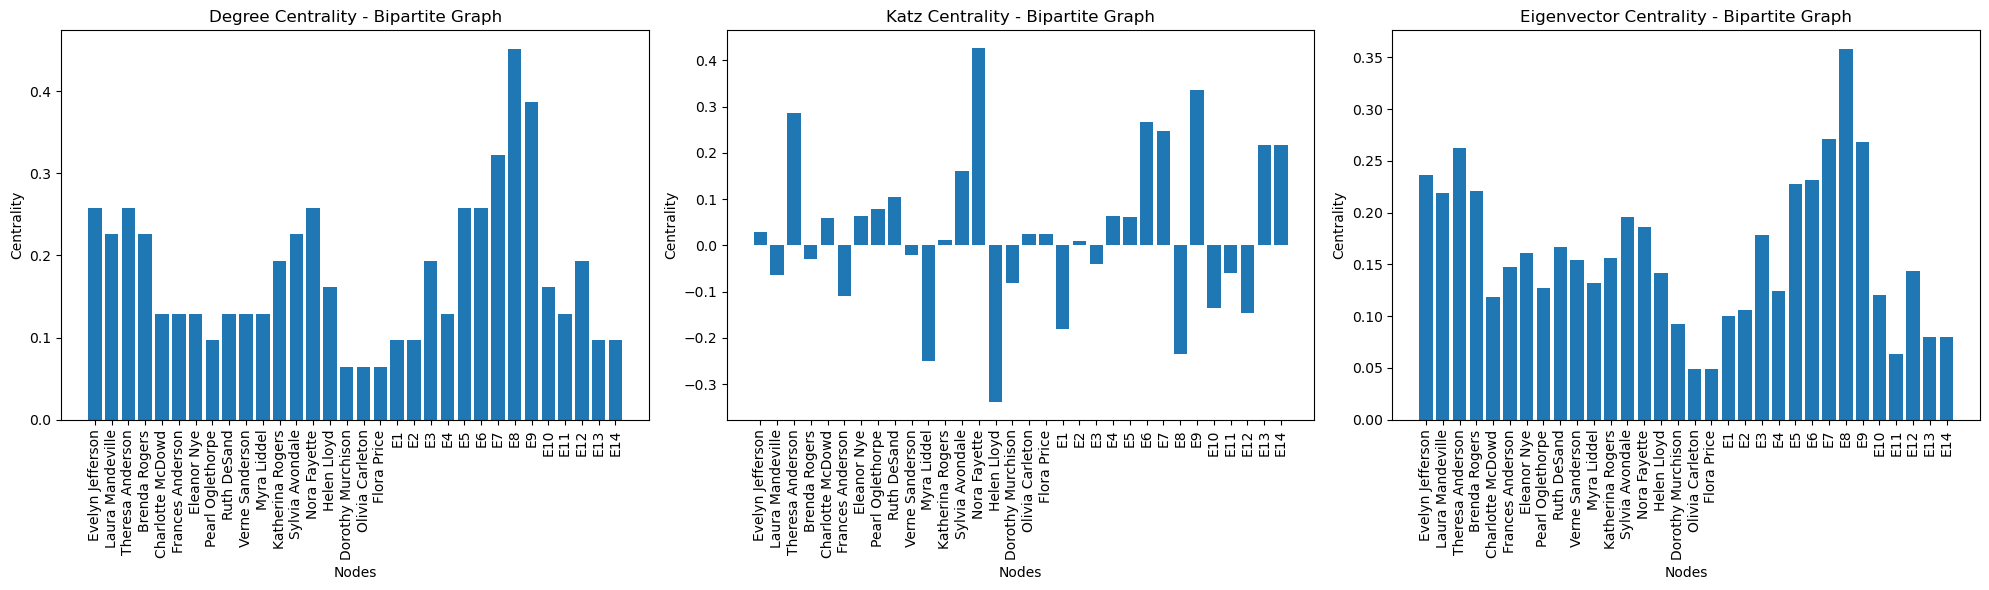

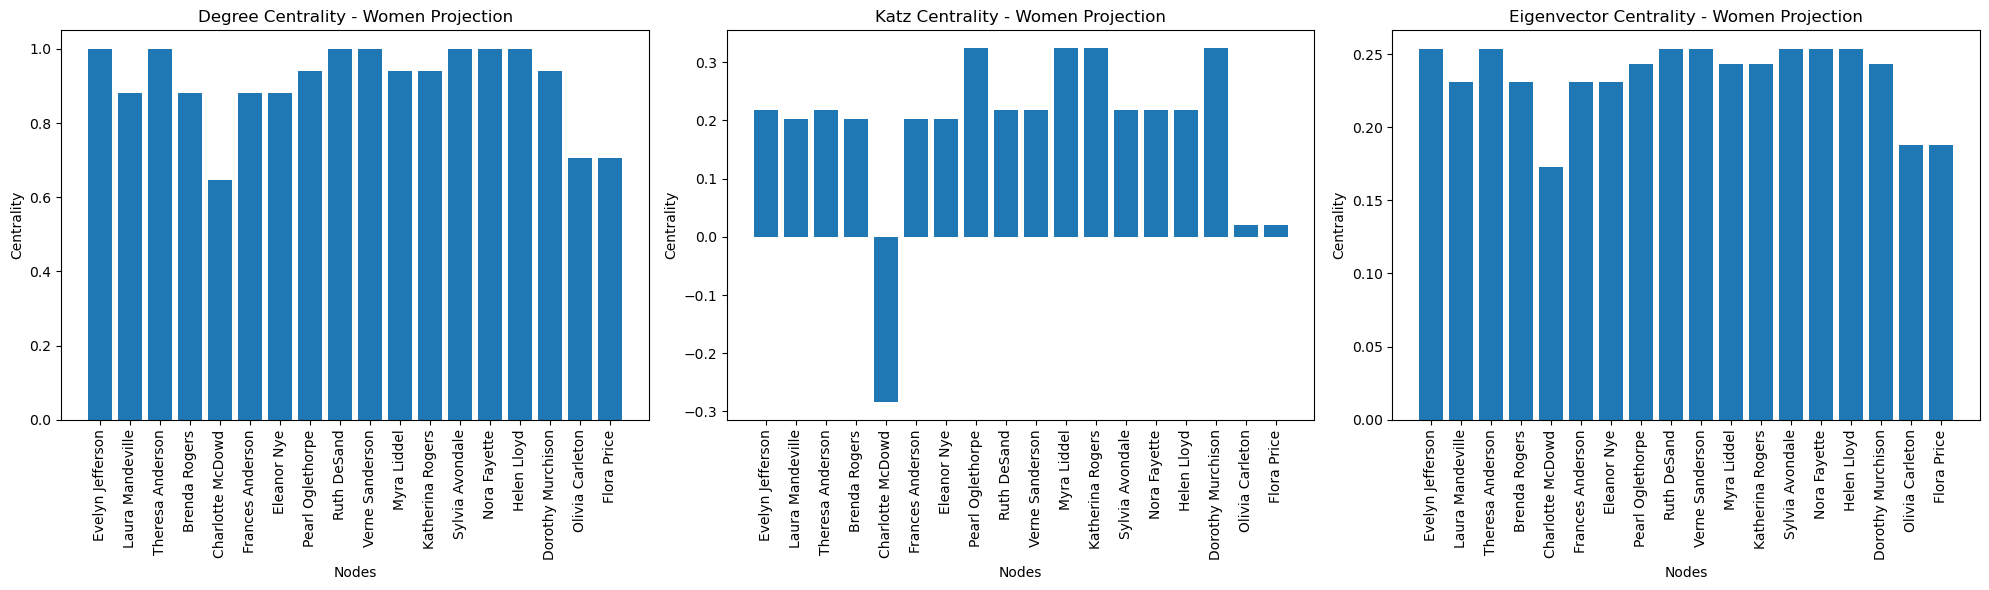

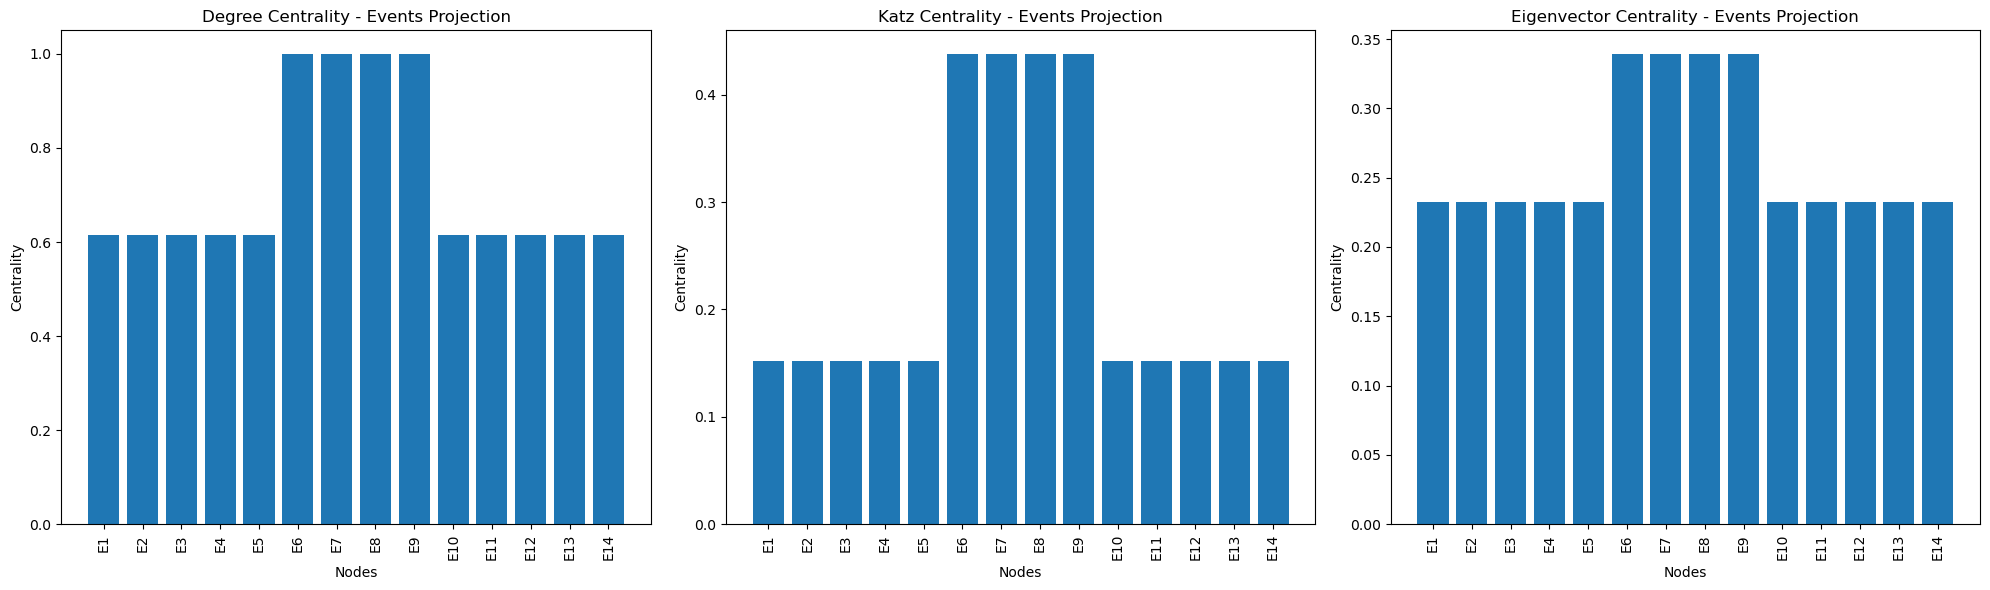

In [7]:
# Create the bipartite graph
G = nx.davis_southern_women_graph()

# Separate the nodes into the two partitions
women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
events = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

# Create the projections
women_graph = nx.bipartite.projected_graph(G, women)
events_graph = nx.bipartite.projected_graph(G, events)

# Function to calculate centralities
def calculate_centralities(graph):
    degree_cent = nx.degree_centrality(graph)
    katz_cent = nx.katz_centrality_numpy(graph, alpha=0.6)
    eigenvector_cent = nx.eigenvector_centrality(graph)
    return degree_cent, katz_cent, eigenvector_cent

# Calculate centralities for all graphs
g_cent = calculate_centralities(G)
women_cent = calculate_centralities(women_graph)
events_cent = calculate_centralities(events_graph)

# Plotting function
def plot_centralities(centralities, graph_name):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    nodes = list(centralities[0].keys())
    degree_values = [centralities[0][node] for node in nodes]
    katz_values = [centralities[1][node] for node in nodes]
    eigenvector_values = [centralities[2][node] for node in nodes]
    
    ax1.bar(nodes, degree_values)
    ax1.set_title(f'Degree Centrality - {graph_name}')
    ax1.set_xlabel('Nodes')
    ax1.set_ylabel('Centrality')
    ax1.tick_params(axis='x', rotation=90)
    
    ax2.bar(nodes, katz_values)
    ax2.set_title(f'Katz Centrality - {graph_name}')
    ax2.set_xlabel('Nodes')
    ax2.set_ylabel('Centrality')
    ax2.tick_params(axis='x', rotation=90)
    
    ax3.bar(nodes, eigenvector_values)
    ax3.set_title(f'Eigenvector Centrality - {graph_name}')
    ax3.set_xlabel('Nodes')
    ax3.set_ylabel('Centrality')
    ax3.tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.savefig(f'figures/centralities_{graph_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot centralities for all graphs
plot_centralities(g_cent, 'Bipartite Graph')
plot_centralities(women_cent, 'Women Projection')
plot_centralities(events_cent, 'Events Projection')

In [17]:
import os
import matplotlib.pyplot as plt
from matplotlib import rc

# Add TeX Live bin directory to PATH (adjust the path as needed)
os.environ['PATH'] += os.pathsep + '/usr/local/texlive/2023/bin/x86_64-linux'

# Verify the update
print("Updated PATH:")
print(os.environ['PATH'])

# Print LaTeX configuration
print("LaTeX configuration:")
print(os.popen("latex --version").read())

# Set specific font sizes
plt.rcParams.update({
    'font.size': 12,          # Global font size
    'axes.titlesize': 11,     # Title font size
    'axes.labelsize': 11,     # X and Y axis labels font size
    'xtick.labelsize': 9,     # X-axis tick labels font size
    'ytick.labelsize': 9,     # Y-axis tick labels font size
    'legend.fontsize': 10,    # Legend font size
})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

Updated PATH:
/opt/anaconda/bin:/home/james/.local/bin:/usr/bin/lua51:/home/james/lua51_env/bin:/usr/condabin:/usr/local/sbin:/usr/local/bin:/usr/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl:/usr/local/texlive/2023/bin/x86_64-linux
LaTeX configuration:
pdfTeX 3.141592653-2.6-1.40.25 (TeX Live 2023)
kpathsea version 6.3.5
Copyright 2023 Han The Thanh (pdfTeX) et al.
There is NO warranty.  Redistribution of this software is
covered by the terms of both the pdfTeX copyright and
the Lesser GNU General Public License.
For more information about these matters, see the file
named COPYING and the pdfTeX source.
Primary author of pdfTeX: Han The Thanh (pdfTeX) et al.
Compiled with libpng 1.6.39; using libpng 1.6.39
Compiled with zlib 1.2.13; using zlib 1.2.13
Compiled with xpdf version 4.04



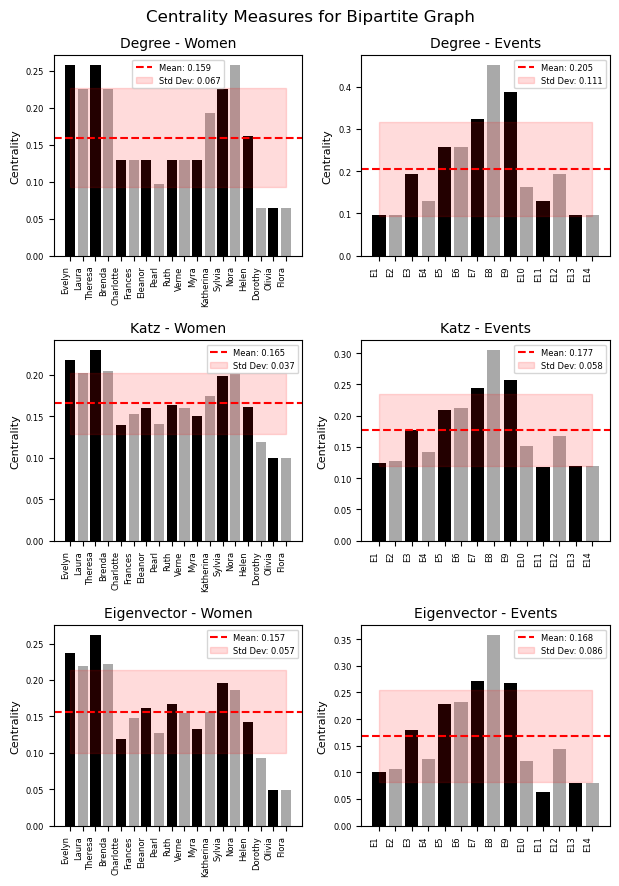

In [8]:
# Calculate centralities
def calculate_centralities(graph):
    degree_cent = nx.degree_centrality(graph)
    katz_cent = nx.katz_centrality_numpy(graph, alpha=0.1)
    eigenvector_cent = nx.eigenvector_centrality(graph)
    return degree_cent, katz_cent, eigenvector_cent

g_cent = calculate_centralities(G)

def plot_centralities_bipartite(centralities, graph_name, women, events):
    fig, axes = plt.subplots(3, 2, figsize=(6.3, 9))  # Changed to 6.3 inches width, adjusted height
    
    for i, node_set in enumerate([women, events]):
        nodes = node_set
        if i == 0:  # For women, use only first names
            nodes = [n.split()[0] for n in nodes]
        degree_values = [centralities[0][node] for node in node_set]
        katz_values = [centralities[1][node] for node in node_set]
        eigenvector_values = [centralities[2][node] for node in node_set]
        
        for j, (values, title) in enumerate(zip([degree_values, katz_values, eigenvector_values], 
                                                ['Degree', 'Katz', 'Eigenvector'])):
            ax = axes[j, i]
            colors = ['black', 'darkgrey']
            ax.bar(range(len(nodes)), values, color=[colors[k % 2] for k in range(len(nodes))])
            ax.set_title(f'{title} - {"Women" if i == 0 else "Events"}', fontsize=10)
            ax.set_ylabel('Centrality', fontsize=8)
            
            # Set x-ticks and labels
            ax.set_xticks(range(len(nodes)))
            ax.set_xticklabels(nodes, rotation=90, ha='right', fontsize=6)
            
            # Adjust y-axis tick label size
            ax.tick_params(axis='y', labelsize=6)
            
            # Calculate and plot mean
            mean_value = np.mean(values)
            ax.axhline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.3f}')
            
            # Calculate and plot standard deviation
            std_dev = np.std(values)
            ax.fill_between(range(len(nodes)), mean_value - std_dev, mean_value + std_dev, 
                            color='r', alpha=0.14, label=f'Std Dev: {std_dev:.3f}')
            
            ax.legend(fontsize=6)
    
    plt.suptitle(f'Centrality Measures for {graph_name}', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'figures/centralities_{graph_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot centralities for the bipartite graph
plot_centralities_bipartite(g_cent, 'Bipartite Graph', women, events)

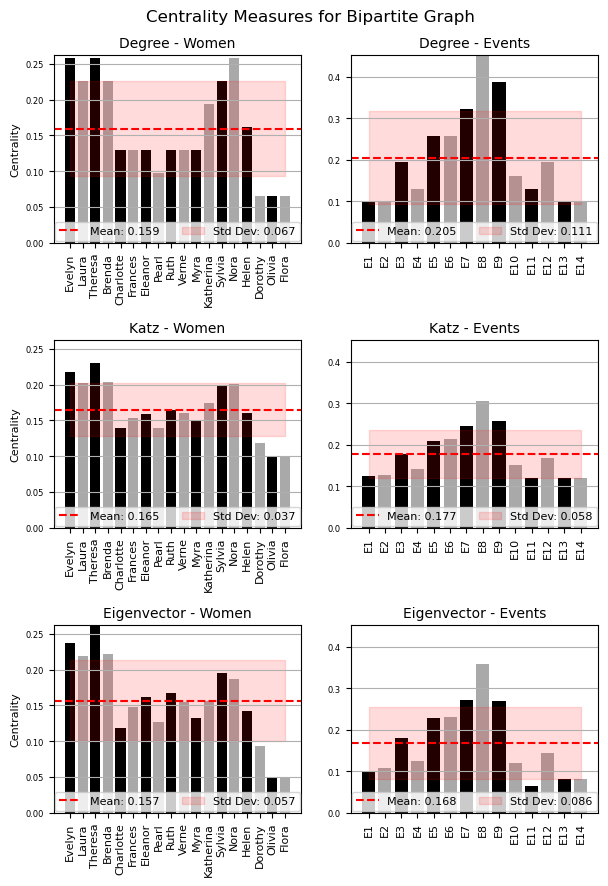

In [32]:
# Create the bipartite graph
G = nx.davis_southern_women_graph()

# Separate the nodes into the two partitions
women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
events = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

# Calculate centralities
def calculate_centralities(graph):
    degree_cent = nx.degree_centrality(graph)
    katz_cent = nx.katz_centrality_numpy(graph, alpha=0.1)
    eigenvector_cent = nx.eigenvector_centrality(graph)
    return degree_cent, katz_cent, eigenvector_cent

g_cent = calculate_centralities(G)

def plot_centralities_bipartite(centralities, graph_name, women, events):
    fig, axes = plt.subplots(3, 2, figsize=(6.3, 9))
    
    # Determine y-axis limits for women and events
    women_max = max(max(centralities[i][node] for node in women) for i in range(3))
    events_max = max(max(centralities[i][node] for node in events) for i in range(3))
    
    for i, node_set in enumerate([women, events]):
        nodes = node_set
        if i == 0:  # For women, use only first names
            nodes = [n.split()[0] for n in nodes]
        
        for j, (values, title) in enumerate(zip(centralities, 
                                                ['Degree', 'Katz', 'Eigenvector'])):
            ax = axes[j, i]
            colors = ['black', 'darkgrey']
            values_list = [values[node] for node in node_set]
            ax.bar(range(len(nodes)), values_list, color=[colors[k % 2] for k in range(len(nodes))])
            ax.set_title(f'{title} - {"Women" if i == 0 else "Events"}', fontsize=10)
            
            if i == 0:
                ax.set_ylabel('Centrality', fontsize=8)
            
            # Set x-ticks and labels
            ax.set_xticks(range(len(nodes)))
            ax.set_xticklabels(nodes, rotation=90, ha='center', fontsize=8)
            
            # Adjust y-axis tick label size
            ax.tick_params(axis='y', labelsize=6)
            
            # Set y-axis limits
            ax.set_ylim(0, women_max if i == 0 else events_max)
            
            # Calculate and plot mean
            mean_value = np.mean(values_list)
            ax.axhline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.3f}')
            
            # Calculate and plot standard deviation
            std_dev = np.std(values_list)
            ax.fill_between(range(len(nodes)), mean_value - std_dev, mean_value + std_dev, 
                            color='r', alpha=0.14, label=f'Std Dev: {std_dev:.3f}')
            
            # Add legend to every plot
            ax.legend(fontsize=8, loc='upper center', bbox_to_anchor=(0.5, 0.14), ncol=2)
            ax.grid(visible=None, which='both', axis='y')
    
    plt.suptitle(f'Centrality Measures for {graph_name}', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'figures/centralities_{graph_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot centralities for the bipartite graph
plot_centralities_bipartite(g_cent, 'Bipartite Graph', women, events)

In [6]:
### cluster 

In [1]:
import networkx as nx
import numpy as np
from scipy import linalg
from community import community_louvain
import pandas as pd
from networkx.algorithms import bipartite
import os

def non_backtracking_method(G):
    A = nx.adjacency_matrix(G).todense()
    D = np.diag(np.sum(A, axis=1).flatten())
    N = G.number_of_nodes()
    
    H_star = np.block([[A, np.eye(N) - D], [np.eye(N), np.zeros((N, N))]])
    eigenvalues = linalg.eigvals(H_star)
    
    radius = np.sqrt(max(abs(eigenvalues)))
    num_clusters = sum(1 for ev in eigenvalues if abs(ev) > radius and np.isreal(ev))
    
    return num_clusters

def louvain_method(G):
    partition = community_louvain.best_partition(G)
    return len(set(partition.values()))

def newman_method(G):
    def modularity_matrix(G):
        A = nx.adjacency_matrix(G).todense()
        k = np.sum(A, axis=1)
        m = np.sum(k) / 2
        return A - np.outer(k, k) / (2 * m)

    def split_network(G, M):
        eigenvalues, eigenvectors = linalg.eigh(M)
        index = np.argmax(eigenvalues)
        if eigenvalues[index] <= 0:
            return None
        v = eigenvectors[:, index]
        return [G.subgraph([n for n, x in enumerate(v) if x >= 0]),
                G.subgraph([n for n, x in enumerate(v) if x < 0])]

    def recursive_bisection(G):
        if G.number_of_nodes() <= 1:
            return [G]
        M = modularity_matrix(G)
        result = split_network(G, M)
        if result is None:
            return [G]
        return recursive_bisection(result[0]) + recursive_bisection(result[1])

    communities = recursive_bisection(G)
    return len(communities)

def modularity_eigengap(G):
    M = nx.modularity_matrix(G)
    eigenvalues = linalg.eigvalsh(M)
    eigenvalues = sorted(eigenvalues, reverse=True)
    gaps = [eigenvalues[i] - eigenvalues[i+1] for i in range(len(eigenvalues)-1)]
    return np.argmax(gaps) + 1

def density_est(G):
    women = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
    density_G = bipartite.density(G, women)
    return round( 1/ density_G, 2)
    

# Create the Davis Southern Women graph
G = nx.davis_southern_women_graph()

# Apply the clustering methods
results = {
    "Network": "Davis Southern Women",
    "Nodes": G.number_of_nodes(),
    "Links": G.number_of_edges(),
    "Non-backtracking": non_backtracking_method(G),
    "Louvain": louvain_method(G),
    "Newman": newman_method(G),
    "Modularity eigengap": modularity_eigengap(G),
    "Density Est": density_est(G)
}

# Create a DataFrame
df = pd.DataFrame([results])

# Generate LaTeX table
latex_table = df.to_latex(index=False, column_format="l|c|c|c|c|c|c|c")

# Ensure the 'tables' directory exists
os.makedirs('tables', exist_ok=True)

# Write the LaTeX table code to a file in the "tables" folder
with open("tables/comparison_clustering.tex", 'w') as f:
    f.write(latex_table)

print("LaTeX table has been saved to 'tables/comparison_clustering.tex'")

# Display the results in the console as well
print(df.to_string(index=False))

LaTeX table has been saved to 'tables/comparison_clustering.tex'
             Network  Nodes  Links  Non-backtracking  Louvain  Newman  Modularity eigengap  Density Est
Davis Southern Women     32     89                 2        3       2                   31         2.83


In [2]:
import networkx as nx
import numpy as np
from scipy import linalg
from community import community_louvain
import pandas as pd
from networkx.algorithms import bipartite
import os

def non_backtracking_method(G):
    A = nx.adjacency_matrix(G).todense()
    D = np.diag(np.sum(A, axis=1).flatten())
    N = G.number_of_nodes()
    
    H_star = np.block([[A, np.eye(N) - D], [np.eye(N), np.zeros((N, N))]])
    eigenvalues = linalg.eigvals(H_star)
    
    radius = np.sqrt(max(abs(eigenvalues)))
    num_clusters = sum(1 for ev in eigenvalues if abs(ev) > radius and np.isreal(ev))
    
    return num_clusters

def louvain_method(G):
    partition = community_louvain.best_partition(G)
    return len(set(partition.values()))

def newman_method(G):
    def modularity_matrix(G):
        A = nx.adjacency_matrix(G).todense()
        k = np.sum(A, axis=1)
        m = np.sum(k) / 2
        return A - np.outer(k, k) / (2 * m)

    def split_network(G, M):
        eigenvalues, eigenvectors = linalg.eigh(M)
        index = np.argmax(eigenvalues)
        if eigenvalues[index] <= 0:
            return None
        v = eigenvectors[:, index]
        return [G.subgraph([n for n, x in enumerate(v) if x >= 0]),
                G.subgraph([n for n, x in enumerate(v) if x < 0])]

    def recursive_bisection(G):
        if G.number_of_nodes() <= 1:
            return [G]
        M = modularity_matrix(G)
        result = split_network(G, M)
        if result is None:
            return [G]
        return recursive_bisection(result[0]) + recursive_bisection(result[1])

    communities = recursive_bisection(G)
    return len(communities)

def modularity_eigengap(G):
    M = nx.modularity_matrix(G)
    eigenvalues = linalg.eigvalsh(M)
    eigenvalues = sorted(eigenvalues, reverse=True)
    gaps = [eigenvalues[i] - eigenvalues[i+1] for i in range(len(eigenvalues)-1)]
    return np.argmax(gaps) + 1

def density_est(G):
    if bipartite.is_bipartite(G):
        women = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
        density_G = bipartite.density(G, women)
    else:
        density_G = nx.density(G)
    return round(1 / density_G, 2)

def compute_metrics(G, name):
    return {
        "Network": name,
        "Nodes": G.number_of_nodes(),
        "Links": G.number_of_edges(),
        "Non-backtracking": non_backtracking_method(G),
        "Louvain": louvain_method(G),
        "Newman": newman_method(G),
        "Modularity eigengap": modularity_eigengap(G),
        "Density Est": density_est(G)
    }

# Create the Davis Southern Women graph
G = nx.davis_southern_women_graph()

# Create the row projection (women projection)
women = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
G_row = bipartite.projected_graph(G, women)

# Apply the clustering methods to both graphs
results_original = compute_metrics(G, "Davis Southern Women")
results_row = compute_metrics(G_row, "Davis Southern Women (Row Projection)")

# Create a DataFrame
df = pd.DataFrame([results_original, results_row])

# Generate LaTeX table
latex_table = df.to_latex(index=False, column_format="l|c|c|c|c|c|c|c")

# Ensure the 'tables' directory exists
os.makedirs('tables', exist_ok=True)

# Write the LaTeX table code to a file in the "tables" folder
with open("tables/comparison_clustering.tex", 'w') as f:
    f.write(latex_table)

print("LaTeX table has been saved to 'tables/comparison_clustering.tex'")

# Display the results in the console as well
print(df.to_string(index=False))

LaTeX table has been saved to 'tables/comparison_clustering.tex'
                              Network  Nodes  Links  Non-backtracking  Louvain  Newman  Modularity eigengap  Density Est
                 Davis Southern Women     32     89                 2        4       2                   31         2.83
Davis Southern Women (Row Projection)     18    139                 1        2       2                    1         1.10


In [31]:

# Create the graph
G = nx.davis_southern_women_graph()

# Get the two sets of nodes
women = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
events = set(G) - women

# Create the projections with weights
women_graph = nx.bipartite.weighted_projected_graph(G, women)
events_graph = nx.bipartite.weighted_projected_graph(G, events)

# Calculate densities
density_G = bipartite.density(G, women)  # or events, either will work

In [32]:
def label_propagation_communities_dict(graph):
    communities = community.label_propagation_communities(graph)
    # Process communities into a dictionary
    community_dict = {}
    for i, comm in enumerate(communities):
        for woman in comm:
            community_dict[woman] = i
    return community_dict

    

In [33]:
def BGC(W, args):
    c = np.array(np.sqrt(W.sum(axis=0))).flatten()
    c[c==0] = 1
    c = 1.0/c
    cinv = diags(c)

    F = normalize(W, norm='l1', axis=1)
    B = W.T
    
    Bc = cinv.dot(B)
    
    m, n = W.shape
    dim = min(int(args.dim * args.k), min(m, n) - 1)

    # print(f"dimension={dim}")

    r = np.array(np.sqrt(W.sum(axis=1))).flatten()
    r[r==0] = 1
    r = 1.0/r
    r = diags(r)
    L = Bc.dot(r)
    U, s, V = svds(L, k=dim)
    s = s**2

    alpha = args.alpha
    s = (1.0-alpha)/(1.0-alpha*(s))
    s = np.array(s).flatten()
    s = diags(s).todense()
    U = np.asarray(U.dot(s))  # Convert to numpy array
    U = np.asarray(F.dot(U))  # Convert to numpy array
    U = normalize(U, norm='l2', axis=1)

    # print("start performing k-means...")
    clustering = KMeans(n_clusters=args.k, random_state=1024).fit(U)
    labels = clustering.labels_

    return labels

def FNEM(W, args):
    c = np.array(np.sqrt(W.sum(axis=0))).flatten()
    c[c==0] = 1
    c = 1.0/c
    c = diags(c)

    P = normalize(W, norm='l1', axis=1)
    R = c.dot(W.T)
    r = np.array(np.sqrt(W.sum(axis=1))).flatten()
    r[r==0] = 1
    r = 1.0/r
    r = diags(r)
    R = R.dot(r)

    m, n = W.shape
    dim = min(int(args.dim * args.k), min(m, n) - 1)

    # print(f"dimension={dim}")

    U, s, V = svds(R, k=dim)
    s = s**2

    alpha = args.alpha
    s = (1.0-alpha)/(1.0-alpha*(s))
    s = np.array(s).flatten()
    s = diags(s).todense()
    U = np.asarray(U.dot(s))
    U = np.asarray(P.dot(U))
    U = normalize(U, norm='l2', axis=1)

    U, s, V = svds(U, k=args.k)

    # FNEM rounding
    C = np.zeros((U.shape[0], args.k))
    for i in range(U.shape[0]):
        j = np.argmax(U[i, :])
        C[i, j] = 1
    C = normalize(C, norm='l2', axis=0)

    for _ in range(100):  # You can adjust the number of iterations
        # Update T
        U_T_C = U.T @ C
        Phi, _, Psi = svd(U_T_C)
        T = Phi @ Psi.T

        # Update C
        C = np.zeros((U.shape[0], args.k))
        UT = U @ T
        for i in range(U.shape[0]):
            j = np.argmax(UT[i, :])
            C[i, j] = 1
        C = normalize(C, norm='l2', axis=0)

    labels = np.argmax(C, axis=1)
    return labels


def SNEM(W, args):
    c = np.array(np.sqrt(W.sum(axis=0))).flatten()
    c[c==0] = 1
    c = 1.0/c
    c = diags(c)

    P = normalize(W, norm='l1', axis=1)
    R = c.dot(W.T)
    r = np.array(np.sqrt(W.sum(axis=1))).flatten()
    r[r==0] = 1
    r = 1.0/r
    r = diags(r)
    R = R.dot(r)

    m, n = W.shape
    dim = min(int(args.dim * args.k), min(m, n) - 1)

    # print(f"dimension={dim}")

    U, s, V = svds(R, k=dim)
    s = s**2

    alpha = args.alpha
    s = (1.0-alpha)/(1.0-alpha*(s))
    s = np.array(s).flatten()
    s = diags(s).todense()
    U = np.asarray(U.dot(s))
    U = np.asarray(P.dot(U))
    U = normalize(np.asarray(U), norm='l2', axis=1)

    U, s, V = svds(U, k=args.k)

    # SNEM rounding
    C = np.zeros((U.shape[0], args.k))
    for i in range(U.shape[0]):
        j = np.argmax(U[i, :])
        C[i, j] = 1
    C = normalize(np.asarray(C), norm='l2', axis=0)

    for _ in range(100):  # You can adjust the number of iterations
        # Update T
        T = U.T @ C

        # Update C
        C = np.zeros((U.shape[0], args.k))
        UT = U @ T
        for i in range(U.shape[0]):
            j = np.argmax(UT[i, :])
            C[i, j] = 1
        C = normalize(np.asarray(C), norm='l2', axis=0)

    labels = np.argmax(C, axis=1)
    return labels

def run_clustering(adj_matrix, algorithm='BGC', k=3, dim=5, alpha=0.2):
    # Convert to scipy sparse matrix if it's not already
    W = csr_matrix(adj_matrix)
    
    # Get dimensions
    m, n = W.shape
    # print(f"Matrix shape: {m} x {n}")
    
    # Adjust k if necessary
    k = min(k, min(m, n) - 1)
    
    # Create args object to mimic the original code's structure
    class Args:
        pass
    args = Args()
    args.k = k
    args.dim = dim
    args.alpha = alpha
    
    if algorithm == 'BGC':
        return BGC(W, args)
    elif algorithm == 'FNEM':
        return FNEM(W, args)
    elif algorithm == 'SNEM':
        return SNEM(W, args)
    else:
        raise ValueError("Unknown algorithm. Choose 'BGC', 'FNEM', or 'SNEM'.")

In [37]:
def apply_community_clustering(G):
    if not nx.is_bipartite(G):
        raise ValueError("The input graph must be bipartite.")
    top_nodes, bottom_nodes = nx.bipartite.sets(G)
    top_projection = nx.bipartite.projected_graph(G, top_nodes)
    
    results = {}
    def time_method(method, *args, **kwargs):
        start_time = time.time()
        result = method(*args, **kwargs)
        end_time = time.time()
        return result, end_time - start_time
    
    methods = [
        ("Louvain", lambda: community_louvain.best_partition(top_projection)),
        ("Label_Propagation", lambda: label_propagation_communities_dict(top_projection)),
        ("Girvan_Newman", lambda: list(next(community.girvan_newman(top_projection)))),
        ("BGC", lambda: run_clustering(nx.adjacency_matrix(G), algorithm='BGC')),
        ("FNEM", lambda: run_clustering(nx.adjacency_matrix(G), algorithm='FNEM')),
        ("SNEM", lambda: run_clustering(nx.adjacency_matrix(G), algorithm='SNEM'))
    ]
    
    for method_name, method_func in tqdm(methods, desc="Applying clustering methods"):
        try:
            communities, time_taken = time_method(method_func)
            print(f"{method_name} took {time_taken:.2f} seconds")
            
            if method_name == "Girvan_Newman":
                community_dict = {node: i for i, comm in enumerate(communities) for node in comm}
            elif isinstance(communities, np.ndarray):  # For BGC, FNEM, and SNEM
                community_dict = {node: label for node, label in zip(G.nodes(), communities)}
            else:
                community_dict = communities
            
            results[method_name] = community_dict
        except Exception as e:
            print(f"{method_name} failed: {str(e)}")
            results[method_name] = {}
    
    return results

def create_comparison_dataframe(G, true_clustering, results):
    all_nodes = set(node for cluster in true_clustering for node in cluster)
    
    # Create a dictionary for true clustering
    true_dict = {}
    for i, cluster in enumerate(true_clustering):
        for node in cluster:
            true_dict[node] = i

    # Create the DataFrame
    df = pd.DataFrame(index=sorted(all_nodes))
    df['True_Clustering'] = df.index.map(true_dict)

    for method, communities in results.items():
        df[method] = df.index.map(communities)

    return df

In [38]:
# Define the true clustering
true_clustering = [
    {"Evelyn Jefferson", "Laura Mandeville", "Theresa Anderson", "Brenda Rogers", "Charlotte McDowd", "Frances Anderson", "Eleanor Nye", "Pearl Oglethorpe", "Ruth DeSand"},
    {"Verne Sanderson", "Myra Liddel", "Katherina Rogers", "Sylvia Avondale", "Nora Fayette", "Helen Lloyd", "Dorothy Murchison", "Olivia Carleton", "Flora Price"}
]

# Apply community clustering
results = apply_community_clustering(G)

# Create and display the comparison DataFrame
comparison_df = create_comparison_dataframe(G, true_clustering, results)
comparison_df.sort_values('True_Clustering')

Applying clustering methods: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 41.22it/s]

Louvain took 0.00 seconds
Label_Propagation took 0.00 seconds
Girvan_Newman took 0.02 seconds
BGC took 0.01 seconds
FNEM took 0.05 seconds
SNEM took 0.06 seconds


,True_Clustering,Louvain,Label_Propagation,Girvan_Newman,BGC,FNEM,SNEM
Brenda Rogers,0,1,0,0,2,0,2
Charlotte McDowd,0,1,0,1,2,0,2
Eleanor Nye,0,1,0,0,2,0,2
Evelyn Jefferson,0,0,0,0,2,0,2
Ruth DeSand,0,1,0,0,2,0,2
Frances Anderson,0,1,0,0,2,0,2
Pearl Oglethorpe,0,0,0,0,1,0,2
Theresa Anderson,0,1,0,0,2,0,2
Laura Mandeville,0,1,0,0,2,0,2
Sylvia Avondale,1,0,0,0,1,0,2


In [85]:
# Create the Davis Southern Women Graph
G = nx.davis_southern_women_graph()

# Get the women nodes in the order they appear in the graph
women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]

# Create a dictionary to map full names to their position in the women list
name_to_index = {name: index for index, name in enumerate(women)}

# Create a new index based on the position of each name in the women list
new_index = [name_to_index[name] for name in comparison_df.index]

# Create a new 'Name' column from the current index
comparison_df['Name'] = comparison_df.index

# Set the new index
comparison_df.index = new_index

# Sort the dataframe by the new index
comparison_df = comparison_df.sort_index()

# Reset the index to create a simple numeric index
comparison_df = comparison_df.reset_index(drop=True)

# Reorder columns to put 'Name' first
columns = ['Name'] + [col for col in comparison_df.columns if col != 'Name']
comparison_df = comparison_df[columns]
comparison_df

,Name,True_Clustering,Louvain,Label_Propagation,Girvan_Newman,BGC,FNEM,SNEM
0,Evelyn Jefferson,0,1,0,0,2,1,1
1,Laura Mandeville,0,1,0,0,2,1,1
2,Theresa Anderson,0,1,0,0,2,1,1
3,Brenda Rogers,0,1,0,0,2,1,1
4,Charlotte McDowd,0,1,0,1,2,1,1
5,Frances Anderson,0,1,0,0,2,1,1
6,Eleanor Nye,0,1,0,0,2,1,1
7,Pearl Oglethorpe,0,0,0,0,1,1,1
8,Ruth DeSand,0,1,0,0,2,1,1
9,Verne Sanderson,1,0,0,0,1,1,1


In [86]:
# Modify Louvain column: map 1 to 0 and 0 to 1
comparison_df['Louvain'] = comparison_df['Louvain'].map({1: 0, 0: 1})

# Modify BGC column: map 2 to 0
comparison_df['BGC'] = comparison_df['BGC'].map({2: 0, 0: 0, 1: 1})

# Display the result
comparison_df

,Name,True_Clustering,Louvain,Label_Propagation,Girvan_Newman,BGC,FNEM,SNEM
0,Evelyn Jefferson,0,0,0,0,0,1,1
1,Laura Mandeville,0,0,0,0,0,1,1
2,Theresa Anderson,0,0,0,0,0,1,1
3,Brenda Rogers,0,0,0,0,0,1,1
4,Charlotte McDowd,0,0,0,1,0,1,1
5,Frances Anderson,0,0,0,0,0,1,1
6,Eleanor Nye,0,0,0,0,0,1,1
7,Pearl Oglethorpe,0,1,0,0,1,1,1
8,Ruth DeSand,0,0,0,0,0,1,1
9,Verne Sanderson,1,1,0,0,1,1,1


In [87]:
# Generate the LaTeX table code
latex_table = comparison_df.to_latex(index=True, header= ['Name','True','Lou', 'LP', 'GN', 'BGC','FNEM', 'SNEM'])

# Write the LaTeX table code to a file in the "tables" folder
with open("tables/comparison_table.tex", 'w') as f:
    f.write(latex_table)

In [21]:
######

import networkx as nx
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering, KMeans, Birch
from sklearn.decomposition import NMF
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn_extra.cluster import KMedoids
from networkx.algorithms import community
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from networkx.algorithms import community


def get_numeric_labels(G, clustering):
    node_to_cluster = {}
    for i, cluster in enumerate(clustering):
        for node in cluster:
            node_to_cluster[node] = i
    return [node_to_cluster[node] for node in G.nodes() if node in node_to_cluster]

def get_women_subgraph(G):
    women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
    return G.subgraph(women)
# Implement clustering algorithms

def leading_eigenvector(G, k):
    communities = community.girvan_newman(G)
    for _ in range(k-1):
        next(communities)
    return list(next(communities))

def girvan_newman(G, k):
    communities = community.girvan_newman(G)
    for _ in range(k-1):
        next(communities)
    return list(next(communities))

def get_women_subgraph(G):
    women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
    return G.subgraph(women)

def spectral_clustering(G, k):
    women_G = get_women_subgraph(G)
    adj_matrix = nx.to_numpy_array(women_G)
    sc = SpectralClustering(n_clusters=k, affinity='precomputed')
    return sc.fit_predict(adj_matrix)

###
def label_propagation(G, k):
    women_G = get_women_subgraph(G)
    communities = community.label_propagation_communities(women_G)
    community_dict = {}
    for i, comm in enumerate(communities):
        for woman in comm:
            community_dict[woman] = i
    return [community_dict[woman] for woman in women_G.nodes()]

def louvain(G, k):
    women_G = get_women_subgraph(G)
    partition = community_louvain.best_partition(women_G)
    return [partition[node] for node in women_G.nodes()]


### edit me

def k_means(G, k):
    women_G = get_women_subgraph(G)
    adj_matrix = nx.to_numpy_array(women_G)
    kmeans = KMeans(n_clusters=k)
    return kmeans.fit_predict(adj_matrix)

def k_medoids(G, k):
    women_G = get_women_subgraph(G)
    adj_matrix = nx.to_numpy_array(women_G)
    kmedoids = KMedoids(n_clusters=k)
    return kmedoids.fit_predict(adj_matrix)

def birch_clustering(G, k):
    women_G = get_women_subgraph(G)
    adj_matrix = nx.to_numpy_array(women_G)
    birch = Birch(n_clusters=k)
    return birch.fit_predict(adj_matrix)

def nmf_clustering(G, k):
    women_G = get_women_subgraph(G)
    adj_matrix = nx.to_numpy_array(women_G)
    model = NMF(n_components=k, init='random', random_state=0)
    W = model.fit_transform(adj_matrix)
    return np.argmax(W, axis=1)



# HOPE (BGC), HOPE+ (FNEM), and HOPE+ (SNEM) implementations

def BGC(W, args):
    c = np.array(np.sqrt(W.sum(axis=0))).flatten()
    c[c==0] = 1
    c = 1.0/c
    cinv = diags(c)

    F = normalize(W, norm='l1', axis=1)
    B = W.T
    
    Bc = cinv.dot(B)
    
    m, n = W.shape
    dim = min(int(args.dim * args.k), min(m, n) - 1)

    r = np.array(np.sqrt(W.sum(axis=1))).flatten()
    r[r==0] = 1
    r = 1.0/r
    r = diags(r)
    L = Bc.dot(r)
    U, s, V = svds(L, k=dim)
    s = s**2

    alpha = args.alpha
    s = (1.0-alpha)/(1.0-alpha*(s))
    s = np.array(s).flatten()
    s = diags(s).todense()
    U = np.asarray(U.dot(s))
    U = np.asarray(F.dot(U))
    U = normalize(U, norm='l2', axis=1)

    clustering = KMeans(n_clusters=args.k, random_state=1024).fit(U)
    labels = clustering.labels_

    return labels

def FNEM(W, args):
    c = np.array(np.sqrt(W.sum(axis=0))).flatten()
    c[c==0] = 1
    c = 1.0/c
    c = diags(c)

    P = normalize(W, norm='l1', axis=1)
    R = c.dot(W.T)
    r = np.array(np.sqrt(W.sum(axis=1))).flatten()
    r[r==0] = 1
    r = 1.0/r
    r = diags(r)
    R = R.dot(r)

    m, n = W.shape
    dim = min(int(args.dim * args.k), min(m, n) - 1)

    U, s, V = svds(R, k=dim)
    s = s**2

    alpha = args.alpha
    s = (1.0-alpha)/(1.0-alpha*(s))
    s = np.array(s).flatten()
    s = diags(s).todense()
    U = np.asarray(U.dot(s))
    U = np.asarray(P.dot(U))
    U = normalize(U, norm='l2', axis=1)

    U, s, V = svds(U, k=args.k)

    # FNEM rounding
    C = np.zeros((U.shape[0], args.k))
    for i in range(U.shape[0]):
        j = np.argmax(U[i, :])
        C[i, j] = 1
    C = normalize(C, norm='l2', axis=0)

    for _ in range(100):
        U_T_C = U.T @ C
        Phi, _, Psi = np.linalg.svd(U_T_C)
        T = Phi @ Psi.T

        C = np.zeros((U.shape[0], args.k))
        UT = U @ T
        for i in range(U.shape[0]):
            j = np.argmax(UT[i, :])
            C[i, j] = 1
        C = normalize(C, norm='l2', axis=0)

    labels = np.argmax(C, axis=1)
    return labels

def SNEM(W, args):
    c = np.array(np.sqrt(W.sum(axis=0))).flatten()
    c[c==0] = 1
    c = 1.0/c
    c = diags(c)

    P = normalize(W, norm='l1', axis=1)
    R = c.dot(W.T)
    r = np.array(np.sqrt(W.sum(axis=1))).flatten()
    r[r==0] = 1
    r = 1.0/r
    r = diags(r)
    R = R.dot(r)

    m, n = W.shape
    dim = min(int(args.dim * args.k), min(m, n) - 1)

    U, s, V = svds(R, k=dim)
    s = s**2

    alpha = args.alpha
    s = (1.0-alpha)/(1.0-alpha*(s))
    s = np.array(s).flatten()
    s = diags(s).todense()
    U = np.asarray(U.dot(s))
    U = np.asarray(P.dot(U))
    U = normalize(np.asarray(U), norm='l2', axis=1)

    U, s, V = svds(U, k=args.k)

    # SNEM rounding
    C = np.zeros((U.shape[0], args.k))
    for i in range(U.shape[0]):
        j = np.argmax(U[i, :])
        C[i, j] = 1
    C = normalize(np.asarray(C), norm='l2', axis=0)

    for _ in range(100):
        T = U.T @ C

        C = np.zeros((U.shape[0], args.k))
        UT = U @ T
        for i in range(U.shape[0]):
            j = np.argmax(UT[i, :])
            C[i, j] = 1
        C = normalize(np.asarray(C), norm='l2', axis=0)

    labels = np.argmax(C, axis=1)
    return labels

def hope(G, k):
    women_G = get_women_subgraph(G)
    adj_matrix = nx.to_numpy_array(women_G)
    W = csr_matrix(adj_matrix)
    
    class Args:
        k = k
        dim = 5
        alpha = 0.2
    
    return BGC(W, Args())

def hope_fnem(G, k):
    women_G = get_women_subgraph(G)
    adj_matrix = nx.to_numpy_array(women_G)
    W = csr_matrix(adj_matrix)
    
    class Args:
        k = k
        dim = 5
        alpha = 0.2
    
    return FNEM(W, Args())

def hope_snem(G, k):
    women_G = get_women_subgraph(G)
    adj_matrix = nx.to_numpy_array(women_G)
    W = csr_matrix(adj_matrix)
    
    class Args:
        k = k
        dim = 5
        alpha = 0.2
    
    return SNEM(W, Args())

# Define the evaluation function
def evaluate(true_labels, pred_labels):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    return nmi, ari

def run_clustering_experiment(G, true_clustering, k):
    women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
    true_labels = get_numeric_labels(G.subgraph(women), true_clustering)


    algorithms = {
        "LE": leading_eigenvector,
        "Girvan-Newman": girvan_newman,
        "SC": spectral_clustering,
        "Label Propagation": label_propagation,
        "Louvain": louvain,
            # "K-Means": k_means,
            # "K-Medoids": k_medoids,
            # "Birch": birch_clustering,
            # "NMF": nmf_clustering,
        "HOPE": hope,
        "HOPE+ (FNEM)": hope_fnem,
        "HOPE+ (SNEM)": hope_snem
    }
    results = {}
    for name, algorithm in algorithms.items():
        try:
            pred_labels = algorithm(G, k)
            if isinstance(pred_labels, list) and isinstance(pred_labels[0], set):
                pred_labels = get_numeric_labels(G.subgraph(women), pred_labels)
            elif isinstance(pred_labels, np.ndarray):
                pred_labels = pred_labels.tolist()
            nmi, ari = evaluate(true_labels, pred_labels)
            results[name] = {"NMI": nmi, "ARI": ari}
        except Exception as e:
            print(f"Error in {name}: {str(e)}")
            results[name] = {"NMI": np.nan, "ARI": np.nan}

    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values("NMI", ascending=False)
    return results_df
# Example usage:
G = nx.davis_southern_women_graph()
true_clustering = [
    {"Evelyn Jefferson", "Laura Mandeville", "Theresa Anderson", "Brenda Rogers", "Charlotte McDowd", "Frances Anderson", "Eleanor Nye", "Pearl Oglethorpe", "Ruth DeSand"},
    {"Verne Sanderson", "Myra Liddel", "Katherina Rogers", "Sylvia Avondale", "Nora Fayette", "Helen Lloyd", "Dorothy Murchison", "Olivia Carleton", "Flora Price"}
]
k = 3  # number of clusters

results = run_clustering_experiment(G, true_clustering, k)
print(results)

                        NMI       ARI
LE                 0.802178  0.800937
Girvan-Newman      0.802178  0.800937
Label Propagation  0.386853  0.000000
Louvain            0.386853  0.000000
SC                 0.278723  0.173981
HOPE+ (FNEM)       0.150097  0.013393
HOPE+ (SNEM)       0.150097  0.013393
HOPE               0.000000  0.000000


/home/james/.conda/envs/gt/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/james/.conda/envs/gt/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [30]:
######
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering, KMeans, Birch
from sklearn.decomposition import NMF
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn_extra.cluster import KMedoids
from networkx.algorithms import community
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from networkx.algorithms import community
import numpy as np
from scipy.sparse import csr_matrix, diags
from sklearn.preprocessing import normalize
from scipy.sparse.linalg import svds
from scipy.linalg import svd



def get_numeric_labels(G, clustering):
    node_to_cluster = {}
    for i, cluster in enumerate(clustering):
        for node in cluster:
            node_to_cluster[node] = i
    return [node_to_cluster[node] for node in G.nodes() if node in node_to_cluster]

def get_women_subgraph(G):
    women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
    return G.subgraph(women)
# Implement clustering algorithms

def leading_eigenvector(G, k):
    communities = community.girvan_newman(G)
    for _ in range(k-1):
        next(communities)
    return list(next(communities))

def girvan_newman(G, k):
    communities = community.girvan_newman(G)
    for _ in range(k-1):
        next(communities)
    return list(next(communities))

def get_women_subgraph(G):
    women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
    return G.subgraph(women)

def spectral_clustering(G, k):
    women_G = get_women_subgraph(G)
    adj_matrix = nx.to_numpy_array(women_G)
    sc = SpectralClustering(n_clusters=k, affinity='precomputed', n_init=100, assign_labels='discretize')
    return sc.fit_predict(adj_matrix)

###
def label_propagation(G, k):
    women_G = get_women_subgraph(G)
    communities = community.label_propagation_communities(women_G)
    community_dict = {}
    for i, comm in enumerate(communities):
        for woman in comm:
            community_dict[woman] = i
    return [community_dict[woman] for woman in women_G.nodes()]

def louvain(G, k):
    women_G = get_women_subgraph(G)
    partition = community_louvain.best_partition(women_G)
    return [partition[node] for node in women_G.nodes()]


### edit me
def BGC(W, args):
    c = np.array(np.sqrt(W.sum(axis=0))).flatten()
    c[c==0] = 1
    c = 1.0/c
    cinv = diags(c)

    F = normalize(W, norm='l1', axis=1)
    B = W.T
    
    Bc = cinv.dot(B)
    
    m, n = W.shape
    dim = min(int(args.dim * args.k), min(m, n) - 1)

    # print(f"dimension={dim}")

    r = np.array(np.sqrt(W.sum(axis=1))).flatten()
    r[r==0] = 1
    r = 1.0/r
    r = diags(r)
    L = Bc.dot(r)
    U, s, V = svds(L, k=dim)
    s = s**2

    alpha = args.alpha
    s = (1.0-alpha)/(1.0-alpha*(s))
    s = np.array(s).flatten()
    s = diags(s).todense()
    U = np.asarray(U.dot(s))  # Convert to numpy array
    U = np.asarray(F.dot(U))  # Convert to numpy array
    U = normalize(U, norm='l2', axis=1)

    # print("start performing k-means...")
    clustering = KMeans(n_clusters=args.k, random_state=1024).fit(U)
    labels = clustering.labels_

    return labels

def FNEM(W, args):
    c = np.array(np.sqrt(W.sum(axis=0))).flatten()
    c[c==0] = 1
    c = 1.0/c
    c = diags(c)

    P = normalize(W, norm='l1', axis=1)
    R = c.dot(W.T)
    r = np.array(np.sqrt(W.sum(axis=1))).flatten()
    r[r==0] = 1
    r = 1.0/r
    r = diags(r)
    R = R.dot(r)

    m, n = W.shape
    dim = min(int(args.dim * args.k), min(m, n) - 1)

    # print(f"dimension={dim}")

    U, s, V = svds(R, k=dim)
    s = s**2

    alpha = args.alpha
    s = (1.0-alpha)/(1.0-alpha*(s))
    s = np.array(s).flatten()
    s = diags(s).todense()
    U = np.asarray(U.dot(s))
    U = np.asarray(P.dot(U))
    U = normalize(U, norm='l2', axis=1)

    U, s, V = svds(U, k=args.k)

    # FNEM rounding
    C = np.zeros((U.shape[0], args.k))
    for i in range(U.shape[0]):
        j = np.argmax(U[i, :])
        C[i, j] = 1
    C = normalize(C, norm='l2', axis=0)

    for _ in range(100):  # You can adjust the number of iterations
        # Update T
        U_T_C = U.T @ C
        Phi, _, Psi = svd(U_T_C)
        T = Phi @ Psi.T

        # Update C
        C = np.zeros((U.shape[0], args.k))
        UT = U @ T
        for i in range(U.shape[0]):
            j = np.argmax(UT[i, :])
            C[i, j] = 1
        C = normalize(C, norm='l2', axis=0)

    labels = np.argmax(C, axis=1)
    return labels


def SNEM(W, args):
    c = np.array(np.sqrt(W.sum(axis=0))).flatten()
    c[c==0] = 1
    c = 1.0/c
    c = diags(c)

    P = normalize(W, norm='l1', axis=1)
    R = c.dot(W.T)
    r = np.array(np.sqrt(W.sum(axis=1))).flatten()
    r[r==0] = 1
    r = 1.0/r
    r = diags(r)
    R = R.dot(r)

    m, n = W.shape
    dim = min(int(args.dim * args.k), min(m, n) - 1)

    # print(f"dimension={dim}")

    U, s, V = svds(R, k=dim)
    s = s**2

    alpha = args.alpha
    s = (1.0-alpha)/(1.0-alpha*(s))
    s = np.array(s).flatten()
    s = diags(s).todense()
    U = np.asarray(U.dot(s))
    U = np.asarray(P.dot(U))
    U = normalize(np.asarray(U), norm='l2', axis=1)

    U, s, V = svds(U, k=args.k)

    # SNEM rounding
    C = np.zeros((U.shape[0], args.k))
    for i in range(U.shape[0]):
        j = np.argmax(U[i, :])
        C[i, j] = 1
    C = normalize(np.asarray(C), norm='l2', axis=0)

    for _ in range(100):  # You can adjust the number of iterations
        # Update T
        T = U.T @ C

        # Update C
        C = np.zeros((U.shape[0], args.k))
        UT = U @ T
        for i in range(U.shape[0]):
            j = np.argmax(UT[i, :])
            C[i, j] = 1
        C = normalize(np.asarray(C), norm='l2', axis=0)

    labels = np.argmax(C, axis=1)
    return labels

def run_clustering(adj_matrix, algorithm='BGC', k=3, dim=5, alpha=0.2):
    # Convert to scipy sparse matrix if it's not already
    W = csr_matrix(adj_matrix)
    
    # Get dimensions
    m, n = W.shape
    # print(f"Matrix shape: {m} x {n}")
    
    # Adjust k if necessary
    k = min(k, min(m, n) - 1)
    
    # Create args object to mimic the original code's structure
    class Args:
        pass
    args = Args()
    args.k = k
    args.dim = dim
    args.alpha = alpha
    
    if algorithm == 'BGC':
        return BGC(W, args)
    elif algorithm == 'FNEM':
        return FNEM(W, args)
    elif algorithm == 'SNEM':
        return SNEM(W, args)
    else:
        raise ValueError("Unknown algorithm. Choose 'BGC', 'FNEM', or 'SNEM'.")

def run_clustering(adj_matrix, algorithm='BGC', k=10, dim=5, alpha=0.3):
    # Convert to scipy sparse matrix if it's not already
    W = csr_matrix(adj_matrix)
    
    # Get dimensions
    m, n = W.shape
    # print(f"Matrix shape: {m} x {n}")
    
    # Adjust k if necessary
    k = min(k, min(m, n) - 1)
    
    # Create args object to mimic the original code's structure
    class Args:
        pass
    args = Args()
    args.k = k
    args.dim = dim
    args.alpha = alpha
    
    if algorithm == 'BGC':
        return BGC(W, args)
    elif algorithm == 'FNEM':
        return FNEM(W, args)
    elif algorithm == 'SNEM':
        return SNEM(W, args)
    else:
        raise ValueError("Unknown algorithm. Choose 'BGC', 'FNEM', or 'SNEM'.")





# Define the evaluation function
def evaluate(true_labels, pred_labels):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    return nmi, ari

def run_clustering_experiment(G, true_clustering, k):
    women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
    true_labels = get_numeric_labels(G.subgraph(women), true_clustering)
    adj_matrix = nx.adjacency_matrix(G)  # Get the adjacency matrix


    algorithms = {
        "LE": leading_eigenvector,
        "Girvan-Newman": girvan_newman,
        "SC": spectral_clustering,
        "Label Propagation": label_propagation,
        "Louvain": louvain,
        "BGC": lambda G, k: run_clustering(adj_matrix, algorithm='BGC', k=k),
        "FNEM": lambda G, k: run_clustering(adj_matrix, algorithm='FNEM', k=k),
        "SNEM": lambda G, k: run_clustering(adj_matrix, algorithm='SNEM', k=k)
    }
    results = {}
    for name, algorithm in algorithms.items():
        try:
            pred_labels = algorithm(G, k)
            if isinstance(pred_labels, list) and isinstance(pred_labels[0], set):
                pred_labels = get_numeric_labels(G.subgraph(women), pred_labels)
            elif isinstance(pred_labels, np.ndarray):
                pred_labels = pred_labels.tolist()
            nmi, ari = evaluate(true_labels, pred_labels)
            results[name] = {"NMI": nmi, "ARI": ari}
        except Exception as e:
            print(f"Error in {name}: {str(e)}")
            results[name] = {"NMI": np.nan, "ARI": np.nan}

    results_df = pd.DataFrame(results).T
    results_df = results_df.sort_values("NMI", ascending=False)
    return results_df
# Example usage:
G = nx.davis_southern_women_graph()
true_clustering = [
    {"Evelyn Jefferson", "Laura Mandeville", "Theresa Anderson", "Brenda Rogers", "Charlotte McDowd", "Frances Anderson", "Eleanor Nye", "Pearl Oglethorpe", "Ruth DeSand"},
    {"Verne Sanderson", "Myra Liddel", "Katherina Rogers", "Sylvia Avondale", "Nora Fayette", "Helen Lloyd", "Dorothy Murchison", "Olivia Carleton", "Flora Price"}
]
k = 3  # number of clusters

results = run_clustering_experiment(G, true_clustering, k)
print(results)

Error in BGC: Found input variables with inconsistent numbers of samples: [18, 32]
Error in FNEM: Found input variables with inconsistent numbers of samples: [18, 32]
Error in SNEM: Found input variables with inconsistent numbers of samples: [18, 32]
                        NMI       ARI
LE                 0.802178  0.800937
Girvan-Newman      0.802178  0.800937
Label Propagation  0.386853  0.000000
Louvain            0.386853  0.000000
SC                 0.155273  0.089764
BGC                     NaN       NaN
FNEM                    NaN       NaN
SNEM                    NaN       NaN


/home/james/.conda/envs/gt/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [19]:
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def k_means(G, k):
    women_G = get_women_subgraph(G)
    
    # Create feature matrix
    features = []
    for node in women_G.nodes():
        degree = women_G.degree(node)
        clustering_coeff = nx.clustering(women_G, node)
        centrality = nx.eigenvector_centrality(women_G)[node]
        features.append([degree, clustering_coeff, centrality])
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Apply KMeans
    kmeans = KMeans(n_clusters=k, n_init=2, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    
    # Print additional information
    print(f"Inertia: {kmeans.inertia_}")
    print(f"Number of iterations: {kmeans.n_iter_}")
    
    return cluster_labels

G = nx.davis_southern_women_graph()

k = 2  # number of clusters
cluster_results = k_means(G, k)

print(f"Cluster assignments: {cluster_results}")

Inertia: 0.0
Number of iterations: 1
Cluster assignments: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/home/james/.conda/envs/gt/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [ ]:

def nrp(G, k):
    # Placeholder for NRP algorithm
    pass

def ppr(G, k):
    # Placeholder for PPR algorithm
    pass

def sbc(G, k):
    # Placeholder for SBC algorithm
    pass

def scc(G, k):
    # Placeholder for SCC algorithm
    pass

def bisbm_kl(G, k):
    # Placeholder for biSBM-KL algorithm
    pass

def bisbm_mcmc(G, k):
    # Placeholder for biSBM-MCMC algorithm
    pass

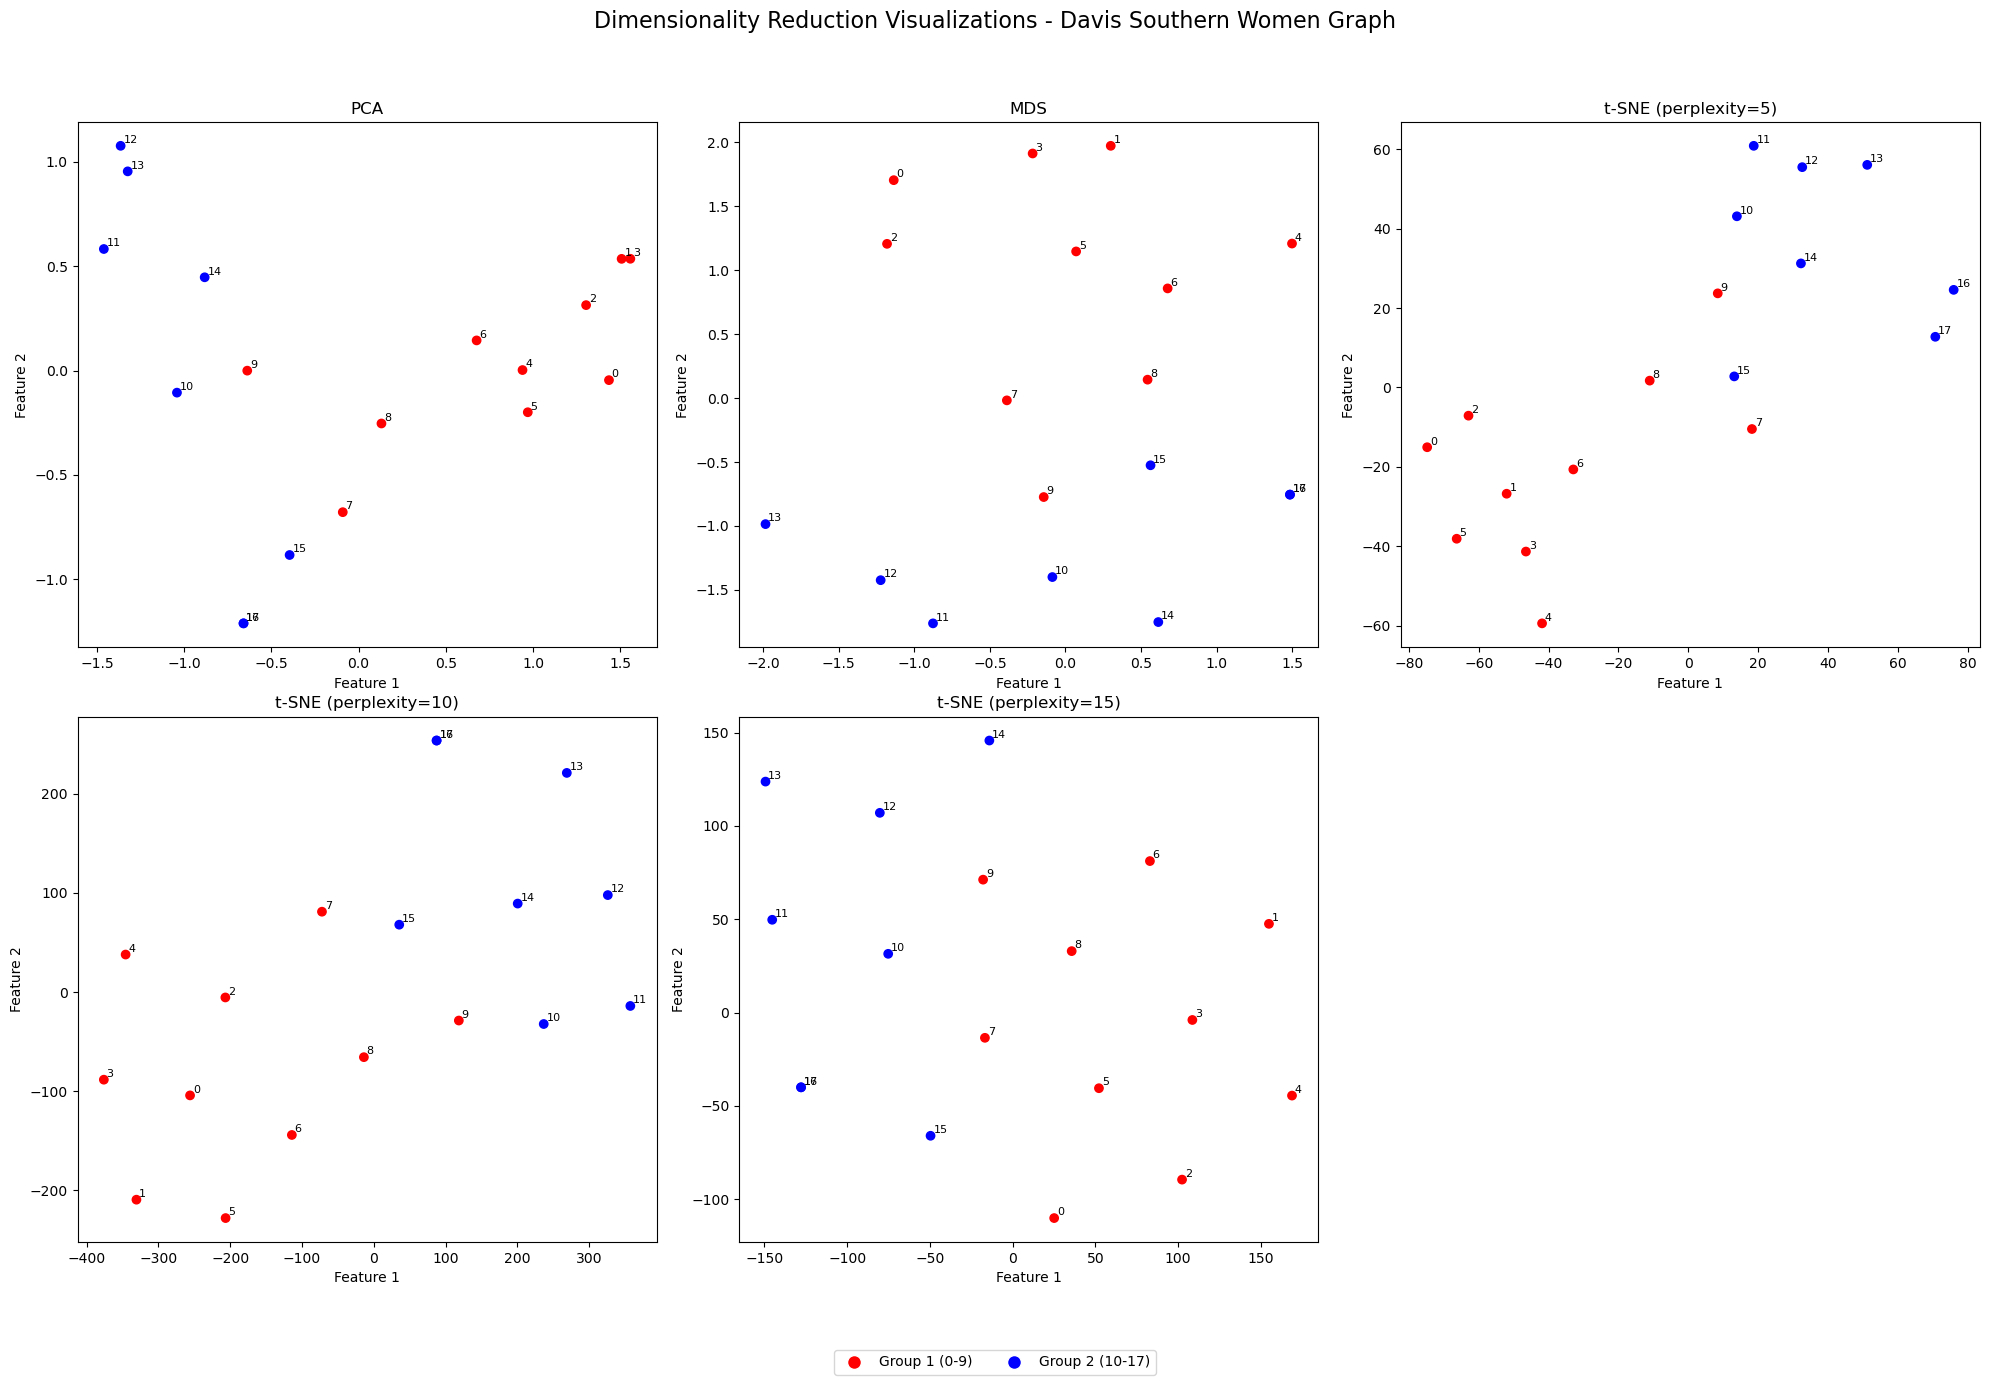

In [107]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA

# Generate the Davis Southern Women graph
G = nx.davis_southern_women_graph()

# Separate the nodes into the two partitions
women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
events = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

# Create the adjacency matrix for women-event connections
adj_matrix = nx.bipartite.biadjacency_matrix(G, women, events).todense()

# Create color assignments: red for indices 0-9, blue for indices 10-17
colors = ['red' if i < 10 else 'blue' for i in range(len(women))]
met ='correlation'
# Define methods and their parameters
methods = [
    ('PCA', PCA(n_components=2, random_state=42)),
    ('MDS', MDS(n_components=2, random_state=42)),
    ('t-SNE (perplexity=5)', TSNE(n_components=2, perplexity=5, random_state=42, metric=met)),
    ('t-SNE (perplexity=10)', TSNE(n_components=2, perplexity=10, random_state=42, metric=met)),
    ('t-SNE (perplexity=15)', TSNE(n_components=2, perplexity=15, random_state=42, metric=met))
]
# Create a grid of plots
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Dimensionality Reduction Visualizations - Davis Southern Women Graph', fontsize=16)

for ax, (method_name, method) in zip(axes.flatten(), methods):
    # Perform dimensionality reduction
    results = method.fit_transform(adj_matrix)
    
    # Plot the results
    scatter = ax.scatter(results[:, 0], results[:, 1], c=colors)
    
    ax.set_title(method_name)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    # Add labels for each point (using index numbers)
    for i, (x, y) in enumerate(results):
        ax.annotate(str(i), (x, y), xytext=(2, 2), textcoords='offset points', fontsize=8)

# Remove the last (empty) subplot
fig.delaxes(axes[1, 2])

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Group 1 (0-9)', markerfacecolor='red', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Group 2 (10-17)', markerfacecolor='blue', markersize=10)]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0))

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.savefig('figures/visual_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()

/home/james/.conda/envs/gt/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


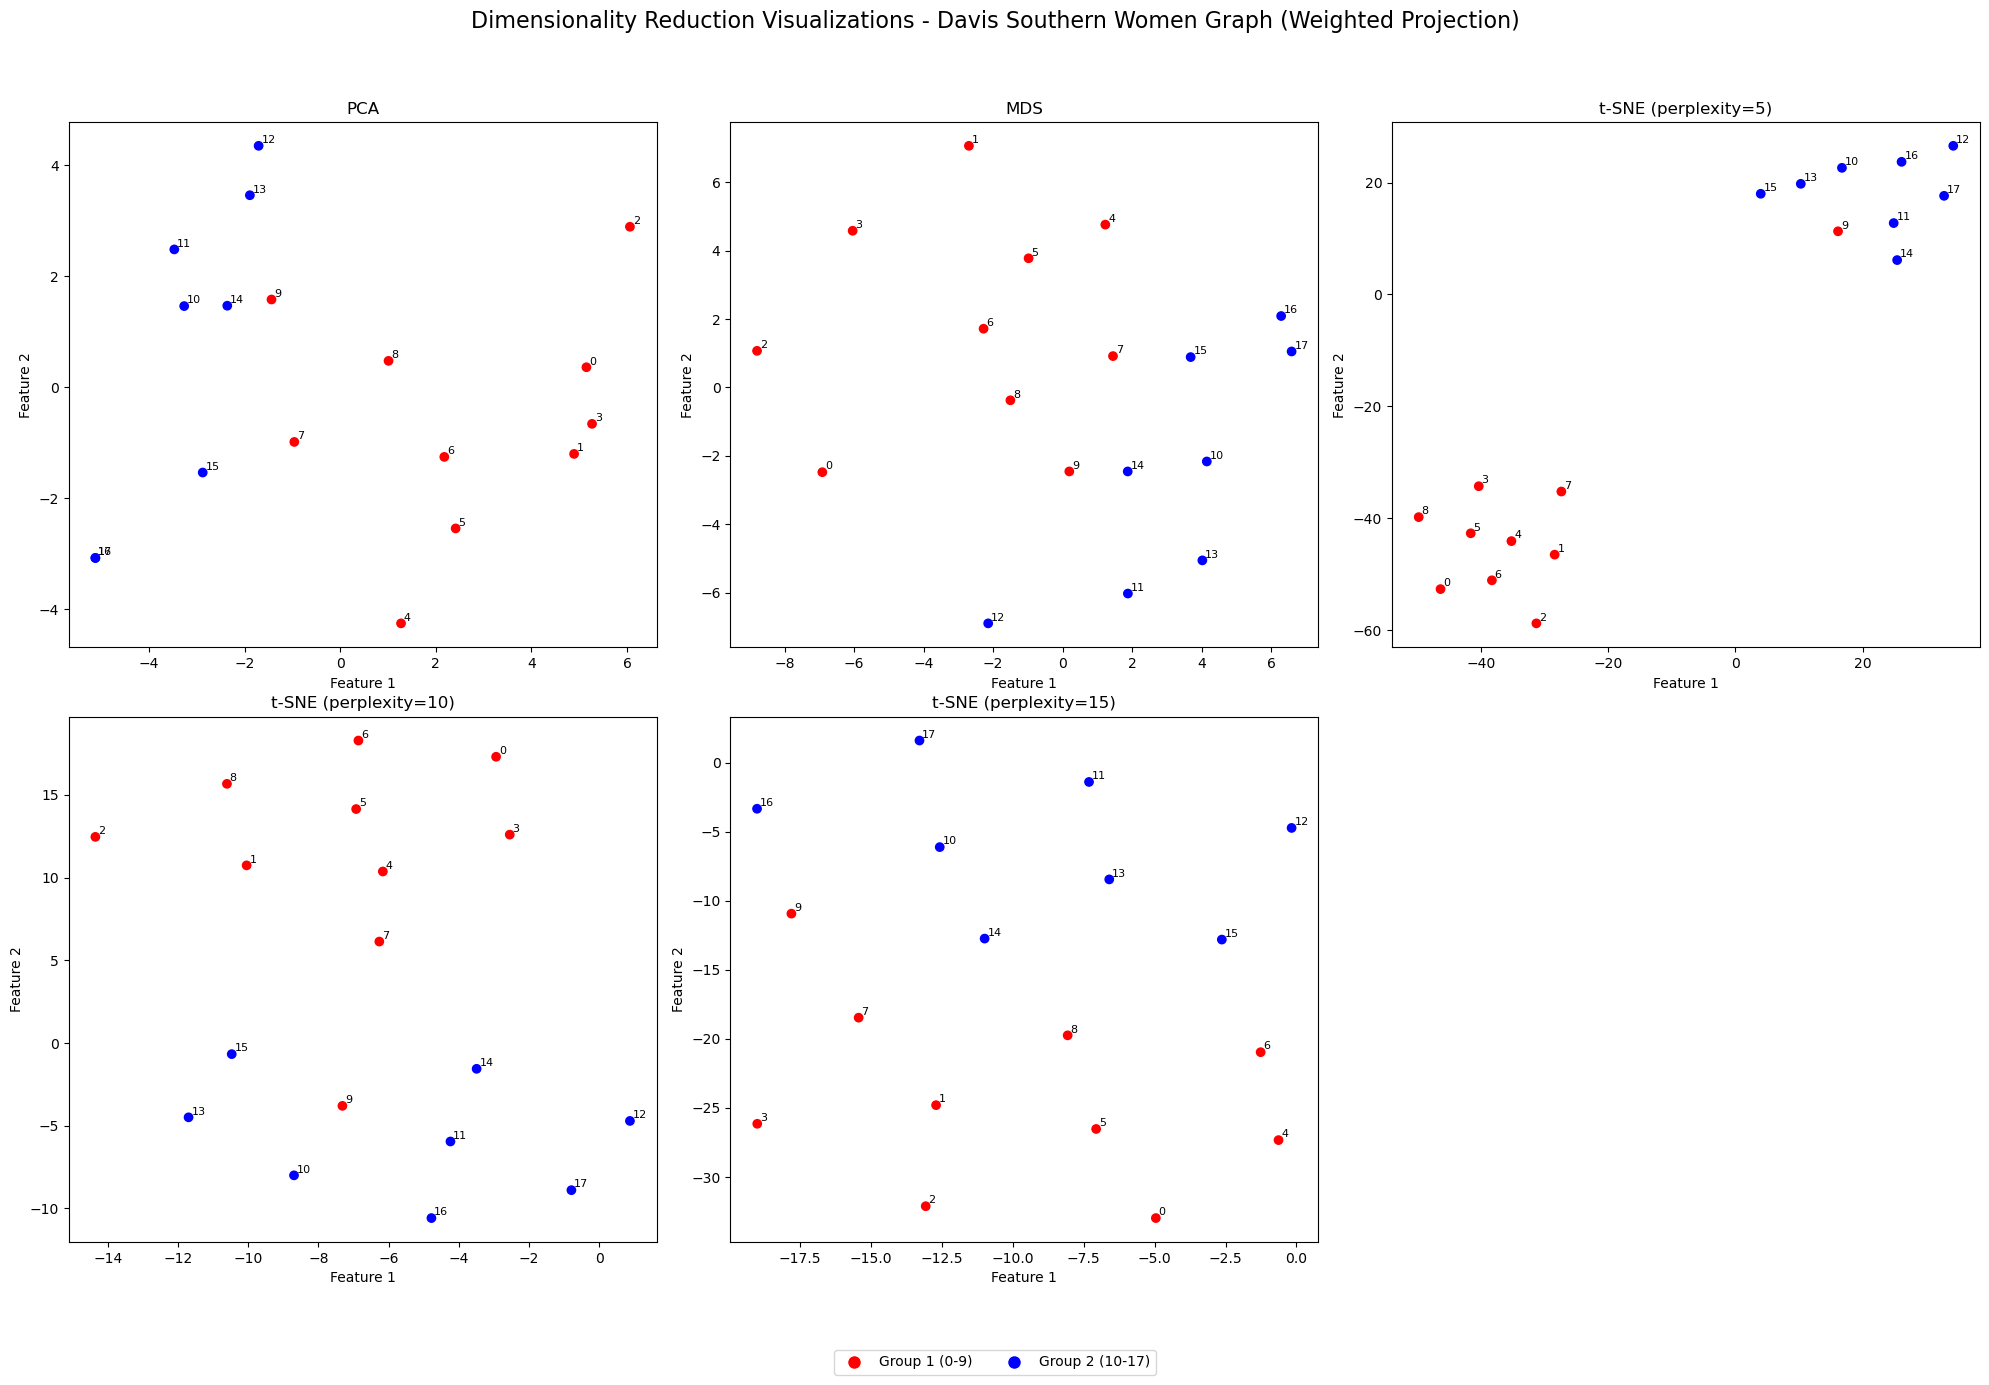

In [108]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA

# Generate the Davis Southern Women graph
G = nx.davis_southern_women_graph()

# Separate the nodes into the two partitions
women = [n for n, d in G.nodes(data=True) if d['bipartite'] == 0]
events = [n for n, d in G.nodes(data=True) if d['bipartite'] == 1]

# Create the weighted projection for women
women_graph = nx.bipartite.weighted_projected_graph(G, women)

# Create the adjacency matrix for the women's projected graph
adj_matrix = nx.adjacency_matrix(women_graph).todense()

# Create color assignments: red for indices 0-9, blue for indices 10-17
colors = ['red' if i < 10 else 'blue' for i in range(len(women))]
met ='correlation'
# Define methods and their parameters
methods = [
    ('PCA', PCA(n_components=2, random_state=42)),
    ('MDS', MDS(n_components=2, random_state=42)),
    ('t-SNE (perplexity=5)', TSNE(n_components=2, perplexity=5, random_state=42, metric=met)),
    ('t-SNE (perplexity=10)', TSNE(n_components=2, perplexity=10, random_state=42, metric=met)),
    ('t-SNE (perplexity=15)', TSNE(n_components=2, perplexity=15, random_state=42, metric=met))
]

# Create a grid of plots
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Dimensionality Reduction Visualizations - Davis Southern Women Graph (Weighted Projection)', fontsize=16)

for ax, (method_name, method) in zip(axes.flatten(), methods):
    # Perform dimensionality reduction
    results = method.fit_transform(adj_matrix)
    
    # Plot the results
    scatter = ax.scatter(results[:, 0], results[:, 1], c=colors)
    
    ax.set_title(method_name)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    # Add labels for each point (using index numbers)
    for i, (x, y) in enumerate(results):
        ax.annotate(str(i), (x, y), xytext=(2, 2), textcoords='offset points', fontsize=8)

# Remove the last (empty) subplot
fig.delaxes(axes[1, 2])

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Group 1 (0-9)', markerfacecolor='red', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Group 2 (10-17)', markerfacecolor='blue', markersize=10)]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0))

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.savefig('figures/visual_embeddings_projected.png', dpi=300, bbox_inches='tight')

plt.show()